## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


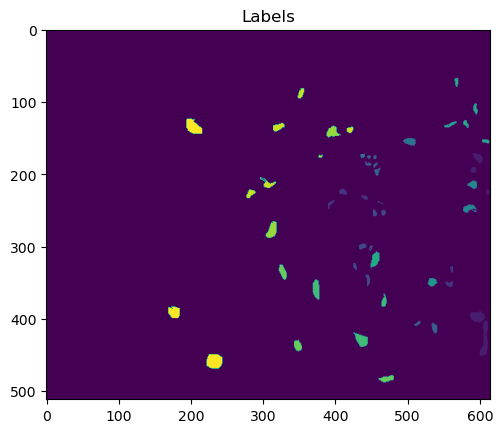

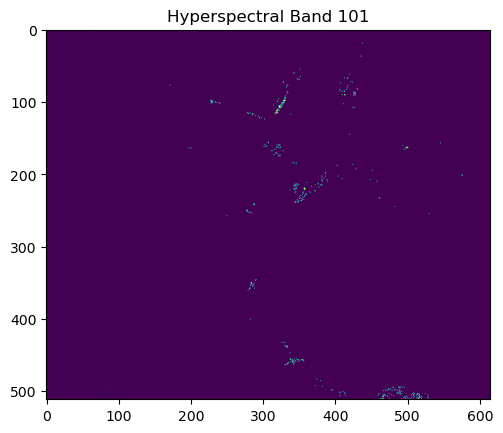

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(130, 5, 5, 176)
(65, 5, 5, 176)
(5016, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 130
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2510, PSNR: 6.0026


Epoch [1/50] Training Loss: 0.2392, PSNR: 5.5381
	[Val]   Batch [1/17] Loss: 0.2224, PSNR: 6.5296
	[Val]   Batch [10/17] Loss: 0.2230, PSNR: 6.5165
Epoch [1/50] Validation Loss: 0.2227, PSNR: 6.5225

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2179, PSNR: 6.6167


Epoch [2/50] Training Loss: 0.2020, PSNR: 6.9523
	[Val]   Batch [1/17] Loss: 0.1787, PSNR: 7.4788
	[Val]   Batch [10/17] Loss: 0.1816, PSNR: 7.4083
Epoch [2/50] Validation Loss: 0.1806, PSNR: 7.4335

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1798, PSNR: 7.4523


Epoch [3/50] Training Loss: 0.1656, PSNR: 7.1295
	[Val]   Batch [1/17] Loss: 0.1427, PSNR: 8.4547
	[Val]   Batch [10/17] Loss: 0.1456, PSNR: 8.3698
Epoch [3/50] Validation Loss: 0.1446, PSNR: 8.3980

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1451, PSNR: 8.3832


Epoch [4/50] Training Loss: 0.1335, PSNR: 8.7522
	[Val]   Batch [1/17] Loss: 0.1173, PSNR: 9.3074
	[Val]   Batch [10/17] Loss: 0.1197, PSNR: 9.2177
Epoch [4/50] Validation Loss: 0.1189, PSNR: 9.2487

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1169, PSNR: 9.3217


Epoch [5/50] Training Loss: 0.1067, PSNR: 9.0592
	[Val]   Batch [1/17] Loss: 0.0935, PSNR: 10.2932
	[Val]   Batch [10/17] Loss: 0.0949, PSNR: 10.2282
Epoch [5/50] Validation Loss: 0.0944, PSNR: 10.2502

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0930, PSNR: 10.3146


Epoch [6/50] Training Loss: 0.0854, PSNR: 10.0252
	[Val]   Batch [1/17] Loss: 0.0764, PSNR: 11.1691
	[Val]   Batch [10/17] Loss: 0.0770, PSNR: 11.1327
Epoch [6/50] Validation Loss: 0.0768, PSNR: 11.1466

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0744, PSNR: 11.2825


Epoch [7/50] Training Loss: 0.0690, PSNR: 11.6154
	[Val]   Batch [1/17] Loss: 0.0627, PSNR: 12.0274
	[Val]   Batch [10/17] Loss: 0.0633, PSNR: 11.9890
Epoch [7/50] Validation Loss: 0.0631, PSNR: 11.9988

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0609, PSNR: 12.1573


Epoch [8/50] Training Loss: 0.0566, PSNR: 12.4753
	[Val]   Batch [1/17] Loss: 0.0522, PSNR: 12.8233
	[Val]   Batch [10/17] Loss: 0.0527, PSNR: 12.7828
Epoch [8/50] Validation Loss: 0.0525, PSNR: 12.7969

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0511, PSNR: 12.9155


Epoch [9/50] Training Loss: 0.0473, PSNR: 13.2533
	[Val]   Batch [1/17] Loss: 0.0443, PSNR: 13.5332
	[Val]   Batch [10/17] Loss: 0.0445, PSNR: 13.5212
Epoch [9/50] Validation Loss: 0.0444, PSNR: 13.5302

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0425, PSNR: 13.7112


Epoch [10/50] Training Loss: 0.0401, PSNR: 13.9768
	[Val]   Batch [1/17] Loss: 0.0381, PSNR: 14.1933
	[Val]   Batch [10/17] Loss: 0.0383, PSNR: 14.1697
Epoch [10/50] Validation Loss: 0.0381, PSNR: 14.1877

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0365, PSNR: 14.3744


Epoch [11/50] Training Loss: 0.0345, PSNR: 14.6285
	[Val]   Batch [1/17] Loss: 0.0328, PSNR: 14.8476
	[Val]   Batch [10/17] Loss: 0.0330, PSNR: 14.8178
Epoch [11/50] Validation Loss: 0.0328, PSNR: 14.8409

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0314, PSNR: 15.0279


Epoch [12/50] Training Loss: 0.0300, PSNR: 15.2330
	[Val]   Batch [1/17] Loss: 0.0288, PSNR: 15.4038
	[Val]   Batch [10/17] Loss: 0.0291, PSNR: 15.3598
Epoch [12/50] Validation Loss: 0.0290, PSNR: 15.3828

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0278, PSNR: 15.5546


Epoch [13/50] Training Loss: 0.0264, PSNR: 15.7905
	[Val]   Batch [1/17] Loss: 0.0253, PSNR: 15.9730
	[Val]   Batch [10/17] Loss: 0.0254, PSNR: 15.9531
Epoch [13/50] Validation Loss: 0.0253, PSNR: 15.9708

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0245, PSNR: 16.1009


Epoch [14/50] Training Loss: 0.0233, PSNR: 16.3210
	[Val]   Batch [1/17] Loss: 0.0226, PSNR: 16.4637
	[Val]   Batch [10/17] Loss: 0.0229, PSNR: 16.4095
Epoch [14/50] Validation Loss: 0.0227, PSNR: 16.4336

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0221, PSNR: 16.5502


Epoch [15/50] Training Loss: 0.0209, PSNR: 16.8057
	[Val]   Batch [1/17] Loss: 0.0204, PSNR: 16.8955
	[Val]   Batch [10/17] Loss: 0.0205, PSNR: 16.8749
Epoch [15/50] Validation Loss: 0.0205, PSNR: 16.8904

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0195, PSNR: 17.0917


Epoch [16/50] Training Loss: 0.0188, PSNR: 17.2695
	[Val]   Batch [1/17] Loss: 0.0184, PSNR: 17.3460
	[Val]   Batch [10/17] Loss: 0.0186, PSNR: 17.2968
Epoch [16/50] Validation Loss: 0.0185, PSNR: 17.3193

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0178, PSNR: 17.4969


Epoch [17/50] Training Loss: 0.0170, PSNR: 17.7049
	[Val]   Batch [1/17] Loss: 0.0166, PSNR: 17.7986
	[Val]   Batch [10/17] Loss: 0.0167, PSNR: 17.7687
Epoch [17/50] Validation Loss: 0.0167, PSNR: 17.7847

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0163, PSNR: 17.8901


Epoch [18/50] Training Loss: 0.0155, PSNR: 17.4041
	[Val]   Batch [1/17] Loss: 0.0153, PSNR: 18.1469
	[Val]   Batch [10/17] Loss: 0.0154, PSNR: 18.1145
Epoch [18/50] Validation Loss: 0.0154, PSNR: 18.1331

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0145, PSNR: 18.4011


Epoch [19/50] Training Loss: 0.0141, PSNR: 18.5054
	[Val]   Batch [1/17] Loss: 0.0140, PSNR: 18.5376
	[Val]   Batch [10/17] Loss: 0.0142, PSNR: 18.4716
Epoch [19/50] Validation Loss: 0.0141, PSNR: 18.5016

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0133, PSNR: 18.7651


Epoch [20/50] Training Loss: 0.0130, PSNR: 18.8773
	[Val]   Batch [1/17] Loss: 0.0129, PSNR: 18.9109
	[Val]   Batch [10/17] Loss: 0.0129, PSNR: 18.8791
Epoch [20/50] Validation Loss: 0.0129, PSNR: 18.9001

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0126, PSNR: 18.9967


Epoch [21/50] Training Loss: 0.0120, PSNR: 19.2202
	[Val]   Batch [1/17] Loss: 0.0120, PSNR: 19.2212
	[Val]   Batch [10/17] Loss: 0.0122, PSNR: 19.1482
Epoch [21/50] Validation Loss: 0.0121, PSNR: 19.1799

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0116, PSNR: 19.3511


Epoch [22/50] Training Loss: 0.0111, PSNR: 19.5672
	[Val]   Batch [1/17] Loss: 0.0110, PSNR: 19.5979
	[Val]   Batch [10/17] Loss: 0.0111, PSNR: 19.5657
Epoch [22/50] Validation Loss: 0.0110, PSNR: 19.5867

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0108, PSNR: 19.6818


Epoch [23/50] Training Loss: 0.0103, PSNR: 19.8836
	[Val]   Batch [1/17] Loss: 0.0103, PSNR: 19.8865
	[Val]   Batch [10/17] Loss: 0.0104, PSNR: 19.8151
Epoch [23/50] Validation Loss: 0.0104, PSNR: 19.8488

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0096, PSNR: 20.1680


Epoch [24/50] Training Loss: 0.0096, PSNR: 20.1884
	[Val]   Batch [1/17] Loss: 0.0095, PSNR: 20.2092
	[Val]   Batch [10/17] Loss: 0.0097, PSNR: 20.1388
Epoch [24/50] Validation Loss: 0.0096, PSNR: 20.1746

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0093, PSNR: 20.3272


Epoch [25/50] Training Loss: 0.0090, PSNR: 20.4830
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5396
	[Val]   Batch [10/17] Loss: 0.0089, PSNR: 20.4950
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5213

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0085, PSNR: 20.7000


Epoch [26/50] Training Loss: 0.0084, PSNR: 20.7689
	[Val]   Batch [1/17] Loss: 0.0083, PSNR: 20.7871
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.7140
Epoch [26/50] Validation Loss: 0.0084, PSNR: 20.7507

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9434


Epoch [27/50] Training Loss: 0.0079, PSNR: 21.0501
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.0755
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0016
Epoch [27/50] Validation Loss: 0.0079, PSNR: 21.0371

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0076, PSNR: 21.2042


Epoch [28/50] Training Loss: 0.0074, PSNR: 20.6203
	[Val]   Batch [1/17] Loss: 0.0075, PSNR: 21.2346
	[Val]   Batch [10/17] Loss: 0.0077, PSNR: 21.1505
Epoch [28/50] Validation Loss: 0.0076, PSNR: 21.1874

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0073, PSNR: 21.3924


Epoch [29/50] Training Loss: 0.0070, PSNR: 20.8817
	[Val]   Batch [1/17] Loss: 0.0071, PSNR: 21.5016
	[Val]   Batch [10/17] Loss: 0.0072, PSNR: 21.4232
Epoch [29/50] Validation Loss: 0.0071, PSNR: 21.4584

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.6322


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.1204
	[Val]   Batch [1/17] Loss: 0.0067, PSNR: 21.7107
	[Val]   Batch [10/17] Loss: 0.0069, PSNR: 21.6212
Epoch [30/50] Validation Loss: 0.0068, PSNR: 21.6613

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 21.9807


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0468
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.0896
	[Val]   Batch [10/17] Loss: 0.0063, PSNR: 21.9874
Epoch [31/50] Validation Loss: 0.0063, PSNR: 22.0335

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0059, PSNR: 22.2922


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.2795
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.2776
	[Val]   Batch [10/17] Loss: 0.0060, PSNR: 22.1838
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.2258

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0059, PSNR: 22.2820


Epoch [33/50] Training Loss: 0.0056, PSNR: 22.5098
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5454
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4492
Epoch [33/50] Validation Loss: 0.0056, PSNR: 22.4938

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7570


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.7270
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7483
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6483
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6913

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7385


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.9408
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9126
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7961
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8444

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0048, PSNR: 23.1590


Epoch [36/50] Training Loss: 0.0048, PSNR: 23.1469
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.1287
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 23.0254
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.0682

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0864


Epoch [37/50] Training Loss: 0.0046, PSNR: 23.3412
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3423
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.2221
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2698

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5576


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5368
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5436
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4231
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4726

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7353


Epoch [39/50] Training Loss: 0.0042, PSNR: 23.7335
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7219
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5828
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6373

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.8025


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.9164
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9419
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.8125
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8631

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9978


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.1009
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0903
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9458
Epoch [41/50] Validation Loss: 0.0040, PSNR: 24.0031

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.1047


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.2727
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2627
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1128
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1713

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4883


Epoch [43/50] Training Loss: 0.0036, PSNR: 23.7534
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.3967
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2373
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.2983

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6499


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.6167
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6529
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4823
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5497

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6683


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7885
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8125
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6520
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7151

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8744


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.9412
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9759
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8028
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8686

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9443


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.1117
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1312
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9498
Epoch [47/50] Validation Loss: 0.0031, PSNR: 25.0196

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2778


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2614
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2473
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0731
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1395

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4490


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.4125
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.4097
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2200
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.2912

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5817


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5611
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5707
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3634
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.4408


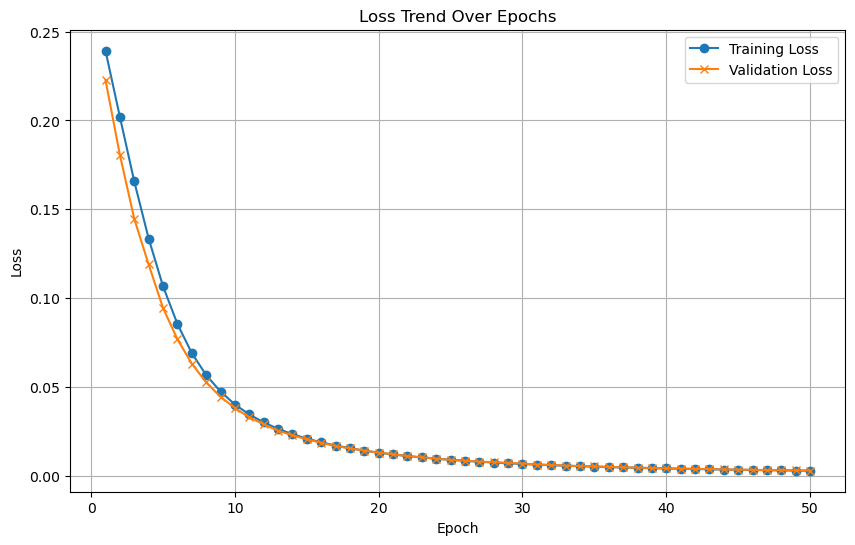

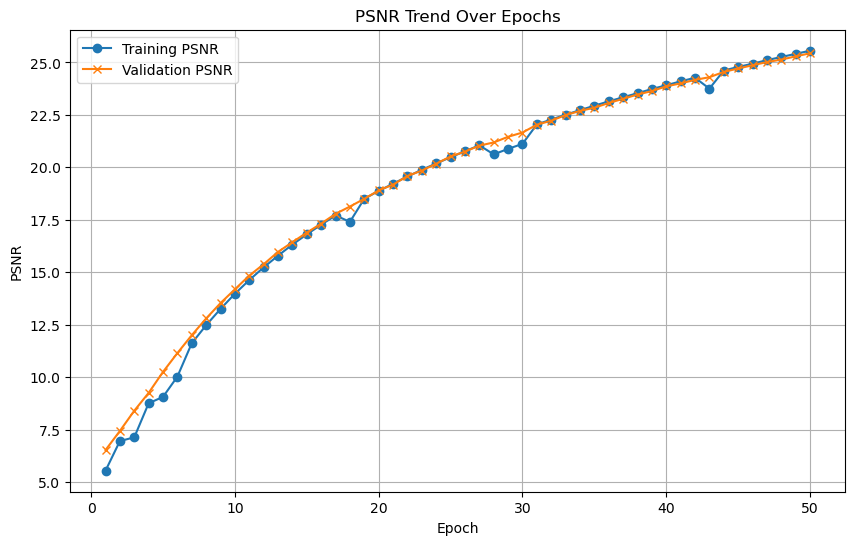

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6562
    Validation Batch [1/1], Loss: 2.5730
Validation Loss: 2.5730, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5730. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6274
    Validation Batch [1/1], Loss: 2.5730
Validation Loss: 2.5730, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6031
    Validation Batch [1/1], Loss: 2.5730
Validation Loss: 2.5730, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5728
    Validation Batch [1/1], Loss: 2.5729
Validation Loss: 2.5729, Validation Accuracy: 7.69%
Validation loss improved from 2.5730 to 2.5729. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.56

Epoch [19/1000] completed, Average Training Loss: 2.4776
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 7.69%
Validation loss improved from 2.5723 to 2.5721. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4587
    Validation Batch [1/1], Loss: 2.5720
Validation Loss: 2.5720, Validation Accuracy: 13.85%
Validation loss improved from 2.5721 to 2.5720. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4445
    Validation Batch [1/1], Loss: 2.5718
Validation Loss: 2.5718, Validation Accuracy: 13.85%
Validation loss improved from 2.5720 to 2.5718. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4343
    Validation Batch [1/1], Loss: 2.5717
Validation Loss: 2.5717, Validation Accuracy: 13.85%
Validation loss improved from 2.5718 to 2.5717. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23

Epoch [29/1000] completed, Average Training Loss: 2.3657
    Validation Batch [1/1], Loss: 2.5698
Validation Loss: 2.5698, Validation Accuracy: 7.69%
Validation loss improved from 2.5701 to 2.5698. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 2.3652
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from 2.5698 to 2.5694. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.3489
    Validation Batch [1/1], Loss: 2.5691
Validation Loss: 2.5691, Validation Accuracy: 7.69%
Validation loss improved from 2.5694 to 2.5691. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.3525
    Validation Batch [1/1], Loss: 2.5689
Validation Loss: 2.5689, Validation Accuracy: 7.69%
Validation loss improved from 2.5691 to 2.5689. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/10

Epoch [49/1000] completed, Average Training Loss: 2.2105
    Validation Batch [1/1], Loss: 2.5576
Validation Loss: 2.5576, Validation Accuracy: 9.23%
Validation loss improved from 2.5589 to 2.5576. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2203
    Validation Batch [1/1], Loss: 2.5562
Validation Loss: 2.5562, Validation Accuracy: 10.77%
Validation loss improved from 2.5576 to 2.5562. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.2009
    Validation Batch [1/1], Loss: 2.5549
Validation Loss: 2.5549, Validation Accuracy: 12.31%
Validation loss improved from 2.5562 to 2.5549. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.1574
    Validation Batch [1/1], Loss: 2.5534
Validation Loss: 2.5534, Validation Accuracy: 12.31%
Validation loss improved from 2.5549 to 2.5534. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53

    Validation Batch [1/1], Loss: 2.5456
Validation Loss: 2.5456, Validation Accuracy: 15.38%
Validation loss improved from 2.5475 to 2.5456. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 2.1756
    Validation Batch [1/1], Loss: 2.5434
Validation Loss: 2.5434, Validation Accuracy: 15.38%
Validation loss improved from 2.5456 to 2.5434. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 2.1257
    Validation Batch [1/1], Loss: 2.5408
Validation Loss: 2.5408, Validation Accuracy: 15.38%
Validation loss improved from 2.5434 to 2.5408. Saving model...

LOG: Epoch [60/1000] - Training
Epoch [60/1000] completed, Average Training Loss: 2.1403
    Validation Batch [1/1], Loss: 2.5380
Validation Loss: 2.5380, Validation Accuracy: 15.38%
Validation loss improved from 2.5408 to 2.5380. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.1119
    Vali

Epoch [77/1000] completed, Average Training Loss: 2.0235
    Validation Batch [1/1], Loss: 2.4052
Validation Loss: 2.4052, Validation Accuracy: 21.54%
Validation loss improved from 2.4200 to 2.4052. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0234
    Validation Batch [1/1], Loss: 2.3899
Validation Loss: 2.3899, Validation Accuracy: 23.08%
Validation loss improved from 2.4052 to 2.3899. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.0201
    Validation Batch [1/1], Loss: 2.3739
Validation Loss: 2.3739, Validation Accuracy: 27.69%
Validation loss improved from 2.3899 to 2.3739. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 2.0248
    Validation Batch [1/1], Loss: 2.3577
Validation Loss: 2.3577, Validation Accuracy: 29.23%
Validation loss improved from 2.3739 to 2.3577. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [8

    Validation Batch [1/1], Loss: 2.3176
Validation Loss: 2.3176, Validation Accuracy: 33.85%
Validation loss improved from 2.3298 to 2.3176. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.9783
    Validation Batch [1/1], Loss: 2.3061
Validation Loss: 2.3061, Validation Accuracy: 32.31%
Validation loss improved from 2.3176 to 2.3061. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.9875
    Validation Batch [1/1], Loss: 2.2955
Validation Loss: 2.2955, Validation Accuracy: 32.31%
Validation loss improved from 2.3061 to 2.2955. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.9812
    Validation Batch [1/1], Loss: 2.2827
Validation Loss: 2.2827, Validation Accuracy: 32.31%
Validation loss improved from 2.2955 to 2.2827. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.9273
    Vali

Epoch [106/1000] completed, Average Training Loss: 1.8410
    Validation Batch [1/1], Loss: 2.0841
Validation Loss: 2.0841, Validation Accuracy: 27.69%
Validation loss improved from 2.0907 to 2.0841. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.8263
    Validation Batch [1/1], Loss: 2.0771
Validation Loss: 2.0771, Validation Accuracy: 29.23%
Validation loss improved from 2.0841 to 2.0771. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.8017
    Validation Batch [1/1], Loss: 2.0726
Validation Loss: 2.0726, Validation Accuracy: 29.23%
Validation loss improved from 2.0771 to 2.0726. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.7878
    Validation Batch [1/1], Loss: 2.0673
Validation Loss: 2.0673, Validation Accuracy: 29.23%
Validation loss improved from 2.0726 to 2.0673. Saving model...

LOG: Epoch [110/1000] - Training


Epoch [113/1000] completed, Average Training Loss: 1.7637
    Validation Batch [1/1], Loss: 2.0479
Validation Loss: 2.0479, Validation Accuracy: 29.23%
Validation loss improved from 2.0511 to 2.0479. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.7693
    Validation Batch [1/1], Loss: 2.0482
Validation Loss: 2.0482, Validation Accuracy: 27.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.7544
    Validation Batch [1/1], Loss: 2.0477
Validation Loss: 2.0477, Validation Accuracy: 27.69%
Validation loss improved from 2.0479 to 2.0477. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.7374
    Validation Batch [1/1], Loss: 2.0500
Validation Loss: 2.0500, Validation Accuracy: 29.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Av

Epoch [133/1000] completed, Average Training Loss: 1.5806
    Validation Batch [1/1], Loss: 2.0096
Validation Loss: 2.0096, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.6203
    Validation Batch [1/1], Loss: 2.0063
Validation Loss: 2.0063, Validation Accuracy: 56.92%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 1.6026
    Validation Batch [1/1], Loss: 1.9781
Validation Loss: 1.9781, Validation Accuracy: 56.92%
Validation loss improved from 1.9955 to 1.9781. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 1.5473
    Validation Batch [1/1], Loss: 1.9528
Validation Loss: 1.9528, Validation Accuracy: 58.46%
Validation loss improved from 1.9781 to 1.9528. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Av

    Validation Batch [1/1], Loss: 1.9521
Validation Loss: 1.9521, Validation Accuracy: 58.46%
Validation loss improved from 1.9528 to 1.9521. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.5490
    Validation Batch [1/1], Loss: 1.9441
Validation Loss: 1.9441, Validation Accuracy: 56.92%
Validation loss improved from 1.9521 to 1.9441. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.5550
    Validation Batch [1/1], Loss: 1.9400
Validation Loss: 1.9400, Validation Accuracy: 56.92%
Validation loss improved from 1.9441 to 1.9400. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.5256
    Validation Batch [1/1], Loss: 1.9196
Validation Loss: 1.9196, Validation Accuracy: 56.92%
Validation loss improved from 1.9400 to 1.9196. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5134


Epoch [161/1000] completed, Average Training Loss: 1.3772
    Validation Batch [1/1], Loss: 1.7566
Validation Loss: 1.7566, Validation Accuracy: 58.46%
Validation loss improved from 1.7640 to 1.7566. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.3350
    Validation Batch [1/1], Loss: 1.7451
Validation Loss: 1.7451, Validation Accuracy: 58.46%
Validation loss improved from 1.7566 to 1.7451. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.3840
    Validation Batch [1/1], Loss: 1.7318
Validation Loss: 1.7318, Validation Accuracy: 60.00%
Validation loss improved from 1.7451 to 1.7318. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.3289
    Validation Batch [1/1], Loss: 1.7253
Validation Loss: 1.7253, Validation Accuracy: 60.00%
Validation loss improved from 1.7318 to 1.7253. Saving model...

LOG: Epoch [165/1000] - Training


Epoch [167/1000] completed, Average Training Loss: 1.2902
    Validation Batch [1/1], Loss: 1.7274
Validation Loss: 1.7274, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.3140
    Validation Batch [1/1], Loss: 1.7177
Validation Loss: 1.7177, Validation Accuracy: 58.46%
Validation loss improved from 1.7231 to 1.7177. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.3005
    Validation Batch [1/1], Loss: 1.7108
Validation Loss: 1.7108, Validation Accuracy: 58.46%
Validation loss improved from 1.7177 to 1.7108. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.2604
    Validation Batch [1/1], Loss: 1.7094
Validation Loss: 1.7094, Validation Accuracy: 56.92%
Validation loss improved from 1.7108 to 1.7094. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000

    Validation Batch [1/1], Loss: 1.6188
Validation Loss: 1.6188, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.1054
    Validation Batch [1/1], Loss: 1.6164
Validation Loss: 1.6164, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.1001
    Validation Batch [1/1], Loss: 1.6084
Validation Loss: 1.6084, Validation Accuracy: 58.46%
Validation loss improved from 1.6163 to 1.6084. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.1518
    Validation Batch [1/1], Loss: 1.6019
Validation Loss: 1.6019, Validation Accuracy: 58.46%
Validation loss improved from 1.6084 to 1.6019. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 1.1103
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.5959
Validation Loss: 1.5959, Validation Accuracy: 63.08%
Validation loss improved from 1.5999 to 1.5959. Saving model...

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 1.1243
    Validation Batch [1/1], Loss: 1.5926
Validation Loss: 1.5926, Validation Accuracy: 61.54%
Validation loss improved from 1.5959 to 1.5926. Saving model...

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.0378
    Validation Batch [1/1], Loss: 1.5895
Validation Loss: 1.5895, Validation Accuracy: 64.62%
Validation loss improved from 1.5926 to 1.5895. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.0718
    Validation Batch [1/1], Loss: 1.5865
Validation Loss: 1.5865, Validation Accuracy: 64.62%
Validation loss improved from 1.5895 to 1.5865. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.0641


Epoch [220/1000] completed, Average Training Loss: 0.9104
    Validation Batch [1/1], Loss: 1.5141
Validation Loss: 1.5141, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.8927
    Validation Batch [1/1], Loss: 1.5290
Validation Loss: 1.5290, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.9347
    Validation Batch [1/1], Loss: 1.5308
Validation Loss: 1.5308, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 0.8946
    Validation Batch [1/1], Loss: 1.5072
Validation Loss: 1.5072, Validation Accuracy: 66.15%
Validation loss improved from 1.5137 to 1.5072. Saving model...

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training 

Epoch [248/1000] completed, Average Training Loss: 0.7288
    Validation Batch [1/1], Loss: 1.4470
Validation Loss: 1.4470, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.7068
    Validation Batch [1/1], Loss: 1.4456
Validation Loss: 1.4456, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.6876
    Validation Batch [1/1], Loss: 1.4149
Validation Loss: 1.4149, Validation Accuracy: 69.23%
Validation loss improved from 1.4290 to 1.4149. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.7232
    Validation Batch [1/1], Loss: 1.4112
Validation Loss: 1.4112, Validation Accuracy: 69.23%
Validation loss improved from 1.4149 to 1.4112. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Av

Epoch [277/1000] completed, Average Training Loss: 0.5825
    Validation Batch [1/1], Loss: 1.3277
Validation Loss: 1.3277, Validation Accuracy: 70.77%
Validation loss improved from 1.3579 to 1.3277. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.5702
    Validation Batch [1/1], Loss: 1.3359
Validation Loss: 1.3359, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.5585
    Validation Batch [1/1], Loss: 1.3497
Validation Loss: 1.3497, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.5684
    Validation Batch [1/1], Loss: 1.3655
Validation Loss: 1.3655, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training 

Epoch [306/1000] completed, Average Training Loss: 0.4529
    Validation Batch [1/1], Loss: 1.2289
Validation Loss: 1.2289, Validation Accuracy: 70.77%
Validation loss improved from 1.2400 to 1.2289. Saving model...

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.4226
    Validation Batch [1/1], Loss: 1.2150
Validation Loss: 1.2150, Validation Accuracy: 70.77%
Validation loss improved from 1.2289 to 1.2150. Saving model...

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.4232
    Validation Batch [1/1], Loss: 1.2019
Validation Loss: 1.2019, Validation Accuracy: 73.85%
Validation loss improved from 1.2150 to 1.2019. Saving model...

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.4312
    Validation Batch [1/1], Loss: 1.1994
Validation Loss: 1.1994, Validation Accuracy: 72.31%
Validation loss improved from 1.2019 to 1.1994. Saving model...

LOG: Epoch [310/1000] - Training


Epoch [338/1000] completed, Average Training Loss: 0.3292
    Validation Batch [1/1], Loss: 1.1307
Validation Loss: 1.1307, Validation Accuracy: 75.38%
Validation loss improved from 1.1368 to 1.1307. Saving model...

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3228
    Validation Batch [1/1], Loss: 1.1235
Validation Loss: 1.1235, Validation Accuracy: 72.31%
Validation loss improved from 1.1307 to 1.1235. Saving model...

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2890
    Validation Batch [1/1], Loss: 1.1298
Validation Loss: 1.1298, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.3460
    Validation Batch [1/1], Loss: 1.1159
Validation Loss: 1.1159, Validation Accuracy: 73.85%
Validation loss improved from 1.1235 to 1.1159. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/1000

Epoch [370/1000] completed, Average Training Loss: 0.2305
    Validation Batch [1/1], Loss: 1.0821
Validation Loss: 1.0821, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2068
    Validation Batch [1/1], Loss: 1.0845
Validation Loss: 1.0845, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.2175
    Validation Batch [1/1], Loss: 1.0814
Validation Loss: 1.0814, Validation Accuracy: 75.38%
Validation loss improved from 1.0815 to 1.0814. Saving model...

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2230
    Validation Batch [1/1], Loss: 1.0835
Validation Loss: 1.0835, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.1039
Validation Loss: 1.1039, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1575
    Validation Batch [1/1], Loss: 1.1000
Validation Loss: 1.1000, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1854
    Validation Batch [1/1], Loss: 1.1112
Validation Loss: 1.1112, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1815
    Validation Batch [1/1], Loss: 1.1334
Validation Loss: 1.1334, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1615
    Validation Batch [1/1], Loss: 1.1179
Validation Loss

    Validation Batch [1/1], Loss: 1.1460
Validation Loss: 1.1460, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1735
    Validation Batch [1/1], Loss: 1.1421
Validation Loss: 1.1421, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1388
    Validation Batch [1/1], Loss: 1.1261
Validation Loss: 1.1261, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.1449
    Validation Batch [1/1], Loss: 1.1264
Validation Loss: 1.1264, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1525
    Validation Batch [1/1], Loss: 1.1327
Validation Loss

Epoch [454/1000] completed, Average Training Loss: 0.1417
    Validation Batch [1/1], Loss: 1.2262
Validation Loss: 1.2262, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1316
    Validation Batch [1/1], Loss: 1.2001
Validation Loss: 1.2001, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1162
    Validation Batch [1/1], Loss: 1.1786
Validation Loss: 1.1786, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1117
    Validation Batch [1/1], Loss: 1.1642
Validation Loss: 1.1642, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.131

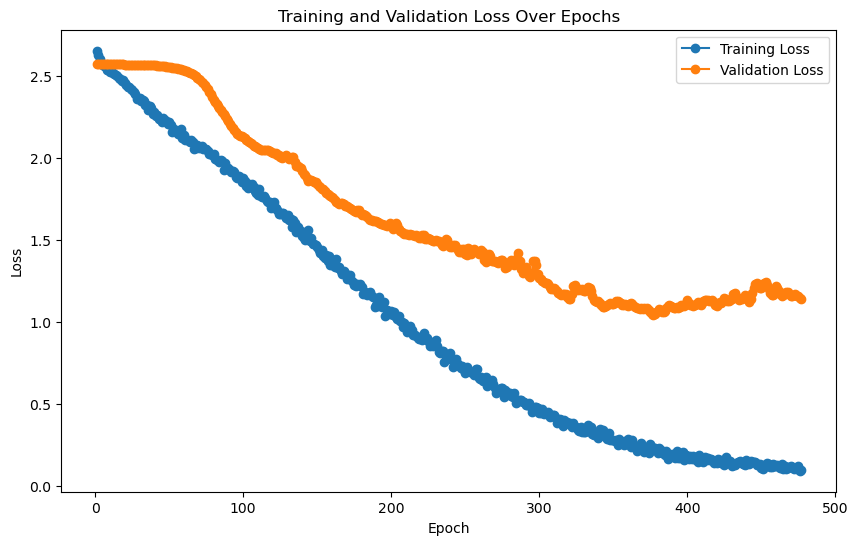

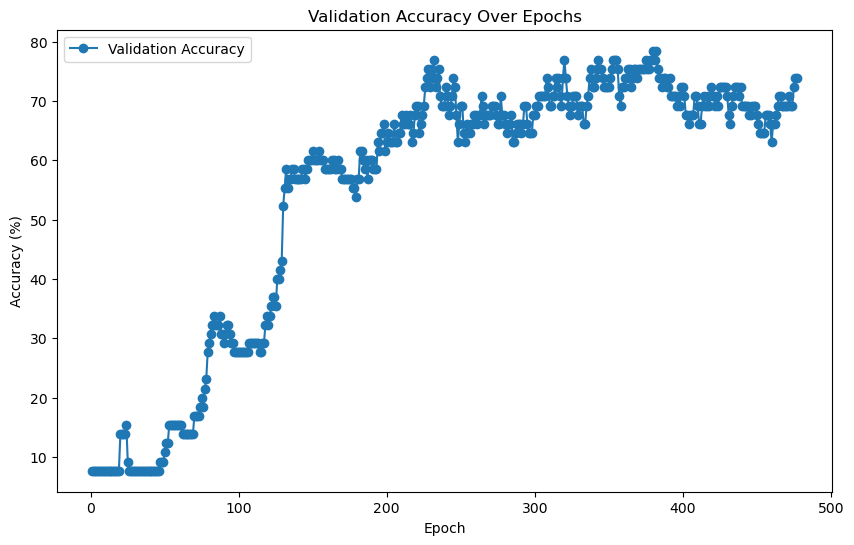


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.7597

Final Test Loss: 0.8738, Test Accuracy: 77.91%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)

LOG: Training features shape: (130, 64), Training labels shape: (130,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5016, 64), Test labels shape: (5016,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 33.85%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)
Train reps shape: (130, 64)
Train labels shape: (130,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5016, 64)
Test labels shape: (5016,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6681  |  Val Loss: 2.7048
Validation loss improved from inf to 2.7048.
[Epoch 2/1000] Train Loss: 2.5656  |  Val Loss: 2.6708
Validation loss improved from 2.7048 to 2.6708.
[Epoch 3/1000] Train Loss: 2.5249  |  Val Loss: 2.6440
Validation loss improved from 2.6708 to 2.6440.
[Epoch 4/1000] Train Loss: 2.5039  |  Val Loss: 2.6373
Validation loss improved from 2.6440 to 2.6373.
[Epoch 5/1000] Train Loss: 2.5110  |  Val Loss: 2.6301
Validation loss improved from 2.6373 to 2.6301.
[Epoch 6/1000] Train Loss: 2.4996  |  Val Loss: 2.6087
Validation loss improved from 2.6301 to 2.6087.
[Epoch 7/1000] Train Loss: 2.4763  |  Val Loss: 2.6013
Validation loss improved from 2.6087 to 2.6013.
[Epoch 8/1000] Train Loss: 2.4746  |  Val Loss: 2.5923
Validation loss improved from 2.6013 to 2.5923.
[Epoch 9/1000] Train Loss: 2.4713  |  Val Loss: 2.5996
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 10/1000] Train Loss: 2.4890  |  Val Loss: 2.6095
!! Validation 

[Epoch 25/1000] Train Loss: 2.4140  |  Val Loss: 2.5511
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 26/1000] Train Loss: 2.4134  |  Val Loss: 2.5486
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 27/1000] Train Loss: 2.4104  |  Val Loss: 2.5469
Validation loss improved from 2.5475 to 2.5469.
[Epoch 28/1000] Train Loss: 2.4067  |  Val Loss: 2.5445
Validation loss improved from 2.5469 to 2.5445.
[Epoch 29/1000] Train Loss: 2.4003  |  Val Loss: 2.5393
Validation loss improved from 2.5445 to 2.5393.
[Epoch 30/1000] Train Loss: 2.3946  |  Val Loss: 2.5349
Validation loss improved from 2.5393 to 2.5349.


[Epoch 31/1000] Train Loss: 2.3868  |  Val Loss: 2.5329
Validation loss improved from 2.5349 to 2.5329.
[Epoch 32/1000] Train Loss: 2.3844  |  Val Loss: 2.5346
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 2.3860  |  Val Loss: 2.5338
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 34/1000] Train Loss: 2.3860  |  Val Loss: 2.5306
Validation loss improved from 2.5329 to 2.5306.
[Epoch 35/1000] Train Loss: 2.3877  |  Val Loss: 2.5427
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 2.4066  |  Val Loss: 2.5618
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 37/1000] Train Loss: 2.4287  |  Val Loss: 2.5611
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 38/1000] Train Loss: 2.4158  |  Val Loss: 2.5502
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 39/1000] Train Loss: 2.4000  |  Val Loss: 2.5497
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 40/1000] Train 

[Epoch 54/1000] Train Loss: 2.3781  |  Val Loss: 2.5406
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 55/1000] Train Loss: 2.3707  |  Val Loss: 2.5419
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 56/1000] Train Loss: 2.3622  |  Val Loss: 2.5404
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 57/1000] Train Loss: 2.3596  |  Val Loss: 2.5447
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 58/1000] Train Loss: 2.3657  |  Val Loss: 2.5616
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 59/1000] Train Loss: 2.3787  |  Val Loss: 2.5678
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 60/1000] Train Loss: 2.3765  |  Val Loss: 2.5685
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 61/1000] Train Loss: 2.3735  |  Val Loss: 2.5633
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 62/1000] Train Loss: 2.3659  |  Val Loss: 2.5695
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 63/1000] Train Loss: 2.3649  |  Val Loss: 2.6064
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 64/1000] Train Loss: 2.3829  |  Val Loss: 2.5895
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 65/1000] Train Loss: 2.3676  |  Val Loss: 2.5668
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 66/1000] Train Loss: 2.3714  |  Val Loss: 2.5554
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 67/1000] Train Loss: 2.3657  |  Val Loss: 2.5414
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 68/1000] Train Loss: 2.3600  |  Val Loss: 2.5490
!! Validation loss did NOT improve !! Patience: 21/100
[

[Epoch 85/1000] Train Loss: 2.3839  |  Val Loss: 2.4701
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 2.3973  |  Val Loss: 2.4786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 2.4119  |  Val Loss: 2.4920
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 2.4197  |  Val Loss: 2.5063
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 2.4266  |  Val Loss: 2.5179
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 2.4276  |  Val Loss: 2.5180
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 91/1000] Train Loss: 2.4113  |  Val Loss: 2.5185
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 92/1000] Train Loss: 2.3942  |  Val Loss: 2.5133
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 93/1000] Train Loss: 2.3838  |  Val Loss: 2.5095
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 94/1000] Train Loss: 2.3743  |  Val Loss: 2.5091
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 95/1000] Train Loss: 2.3690  |  Val Loss: 2.5126
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 96/1000] Train Loss: 2.3662  |  Val Loss: 2.5137
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 97/1000] Train Loss: 2.3616  |  Val Loss: 2.5126
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 98/1000] Train Loss: 2.3580  |  Val Loss: 2.5124
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 99/1000] Train Loss: 2.3550  |  Val Loss: 2.5133
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 100/1000] Train Loss: 2.3540  |  Val Loss: 2.5178
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 101/1000] Train Loss: 2.3524  |  Val Loss: 2.5271
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 102/1000] Train Loss: 2.3540  |  Val Loss: 2.5319
!! Validation loss did NOT improve !! Patience: 18/10

[Epoch 113/1000] Train Loss: 2.3361  |  Val Loss: 2.5418
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 114/1000] Train Loss: 2.3337  |  Val Loss: 2.5454
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 115/1000] Train Loss: 2.3309  |  Val Loss: 2.5506
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 116/1000] Train Loss: 2.3277  |  Val Loss: 2.5566
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 117/1000] Train Loss: 2.3264  |  Val Loss: 2.5618
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 118/1000] Train Loss: 2.3255  |  Val Loss: 2.5578
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 119/1000] Train Loss: 2.3252  |  Val Loss: 2.5404
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 120/1000] Train Loss: 2.3265  |  Val Loss: 2.5246
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 121/1000] Train Loss: 2.3259  |  Val Loss: 2.5014
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 122/1000] Train Loss: 2.3264  |  Val Loss: 2.4803
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 123/1000] Train Loss: 2.3420  |  Val Loss: 2.4782
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 124/1000] Train Loss: 2.3562  |  Val Loss: 2.4749
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 125/1000] Train Loss: 2.3247  |  Val Loss: 2.5158
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 126/1000] Train Loss: 2.3492  |  Val Loss: 2.5480
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 127/1000] Train Loss: 2.3947  |  Val Loss: 2.5528
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 128/1000] Train Loss: 2.4103  |  Val Loss: 2.5425
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 129/1000] Train Loss: 2.3831  |  Val Loss: 2.5202
!! Validation loss did NOT improve !! Patience:

[Epoch 140/1000] Train Loss: 2.3235  |  Val Loss: 2.5297
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 141/1000] Train Loss: 2.3183  |  Val Loss: 2.5358
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 142/1000] Train Loss: 2.3170  |  Val Loss: 2.5481
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 143/1000] Train Loss: 2.3214  |  Val Loss: 2.5715
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 144/1000] Train Loss: 2.3372  |  Val Loss: 2.5844
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 145/1000] Train Loss: 2.3507  |  Val Loss: 2.5882
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 146/1000] Train Loss: 2.3445  |  Val Loss: 2.5731
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 147/1000] Train Loss: 2.3255  |  Val Loss: 2.5506
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 148/1000] Train Loss: 2.3130  |  Val Loss: 2.5327
!! Validation loss did NOT improve !! Patience:

[Epoch 153/1000] Train Loss: 2.3008  |  Val Loss: 2.5457
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 154/1000] Train Loss: 2.2955  |  Val Loss: 2.5548
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 155/1000] Train Loss: 2.2929  |  Val Loss: 2.5696
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 156/1000] Train Loss: 2.2941  |  Val Loss: 2.5940
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 157/1000] Train Loss: 2.3034  |  Val Loss: 2.6311
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 158/1000] Train Loss: 2.3222  |  Val Loss: 2.6466
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 159/1000] Train Loss: 2.3336  |  Val Loss: 2.6397
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 160/1000] Train Loss: 2.3303  |  Val Loss: 2.6192
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 161/1000] Train Loss: 2.3188  |  Val Loss: 2.5977
!! Validation loss did NOT improve !! Patience:

[Epoch 171/1000] Train Loss: 2.2901  |  Val Loss: 2.5696
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 172/1000] Train Loss: 2.2887  |  Val Loss: 2.5732
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 173/1000] Train Loss: 2.2891  |  Val Loss: 2.5802
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 174/1000] Train Loss: 2.2907  |  Val Loss: 2.5887
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 175/1000] Train Loss: 2.2965  |  Val Loss: 2.5948
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 176/1000] Train Loss: 2.2974  |  Val Loss: 2.5906
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 177/1000] Train Loss: 2.2910  |  Val Loss: 2.5785
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 178/1000] Train Loss: 2.2890  |  Val Loss: 2.5666
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 179/1000] Train Loss: 2.2896  |  Val Loss: 2.5729
!! Validation loss did NOT improve !! Patience:

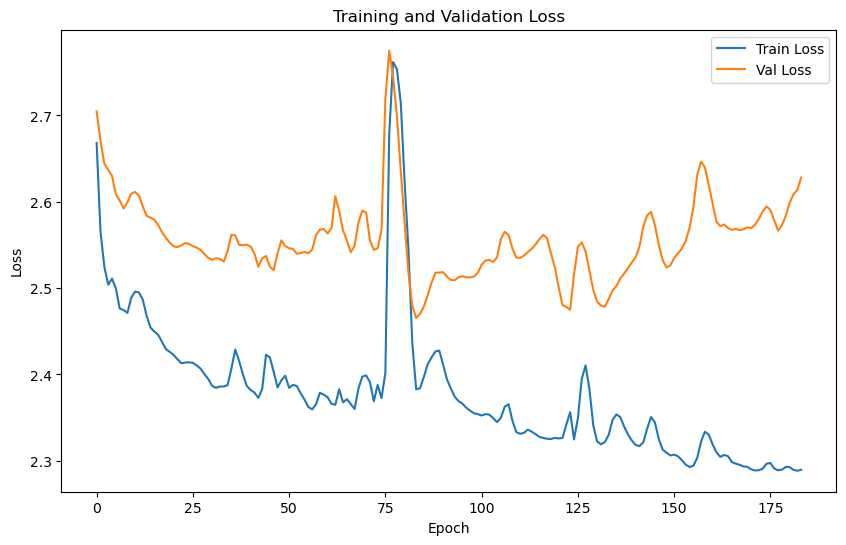

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.5309 | Test Accuracy: 24.94%


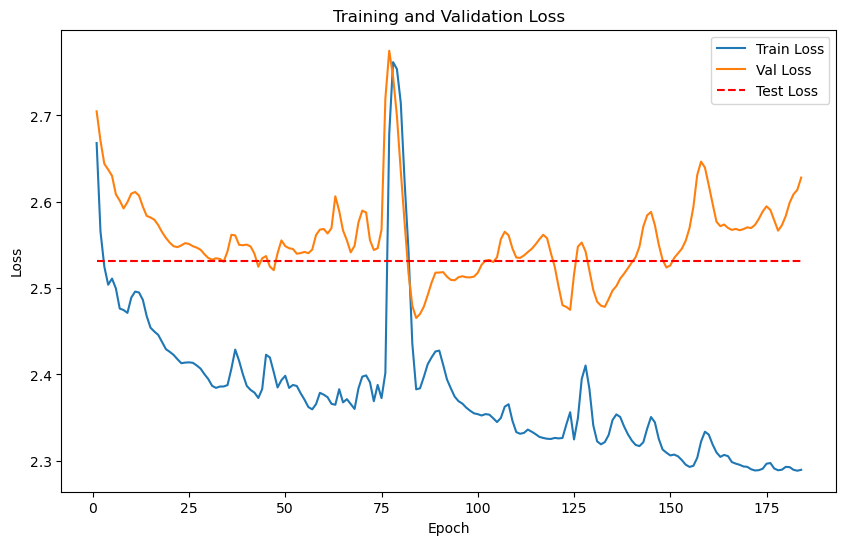

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.7653
Epoch [1/2000], Avg Train Loss: 7.7653


Epoch [1/2000], Avg Val Loss: 5.3428
Validation loss improved from inf to 5.3428. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.6615
Epoch [2/2000], Avg Train Loss: 7.6615
Epoch [2/2000], Avg Val Loss: 5.3129
Validation loss improved from 5.3428 to 5.3129. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.6948
Epoch [3/2000], Avg Train Loss: 7.6948
Epoch [3/2000], Avg Val Loss: 5.2834
Validation loss improved from 5.3129 to 5.2834. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.6317
Epoch [4/2000], Avg Train Loss: 7.6317
Epoch [4/2000], Avg Val Loss: 5.2542
Validation loss improved from 5.2834 to 5.2542. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.4476
Epoch [5/2000], Avg Train Loss: 7.4476
Epoch [5/2000], Avg Val Loss: 5.2251
Validation loss improved from 5.2542 to 5.2251. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.4217
Ep

    Batch [1/1], Train Loss: 6.7163
Epoch [17/2000], Avg Train Loss: 6.7163


Epoch [17/2000], Avg Val Loss: 4.8892
Validation loss improved from 4.9158 to 4.8892. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.8073
Epoch [18/2000], Avg Train Loss: 6.8073
Epoch [18/2000], Avg Val Loss: 4.8628
Validation loss improved from 4.8892 to 4.8628. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.5387
Epoch [19/2000], Avg Train Loss: 6.5387
Epoch [19/2000], Avg Val Loss: 4.8366
Validation loss improved from 4.8628 to 4.8366. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.6751
Epoch [20/2000], Avg Train Loss: 6.6751
Epoch [20/2000], Avg Val Loss: 4.8107
Validation loss improved from 4.8366 to 4.8107. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.6560
Epoch [21/2000], Avg Train Loss: 6.6560
Epoch [21/2000], Avg Val Loss: 4.7852
Validation loss improved from 4.8107 to 4.7852. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Trai

Epoch [29/2000], Avg Val Loss: 4.5946
Validation loss improved from 4.6171 to 4.5946. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.2439
Epoch [30/2000], Avg Train Loss: 6.2439
Epoch [30/2000], Avg Val Loss: 4.5726
Validation loss improved from 4.5946 to 4.5726. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.3023
Epoch [31/2000], Avg Train Loss: 6.3023
Epoch [31/2000], Avg Val Loss: 4.5511
Validation loss improved from 4.5726 to 4.5511. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.2031
Epoch [32/2000], Avg Train Loss: 6.2031
Epoch [32/2000], Avg Val Loss: 4.5300
Validation loss improved from 4.5511 to 4.5300. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.2169
Epoch [33/2000], Avg Train Loss: 6.2169
Epoch [33/2000], Avg Val Loss: 4.5092
Validation loss improved from 4.5300 to 4.5092. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.8272
Epoch [44/2000], Avg Train Loss: 5.8272
Epoch [44/2000], Avg Val Loss: 4.3125
Validation loss improved from 4.3281 to 4.3125. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 5.8767
Epoch [45/2000], Avg Train Loss: 5.8767
Epoch [45/2000], Avg Val Loss: 4.2973
Validation loss improved from 4.3125 to 4.2973. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 5.7181
Epoch [46/2000], Avg Train Loss: 5.7181
Epoch [46/2000], Avg Val Loss: 4.2826
Validation loss improved from 4.2973 to 4.2826. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 5.7664
Epoch [47/2000], Avg Train Loss: 5.7664
Epoch [47/2000], Avg Val Loss: 4.2683
Validation loss improved from 4.2826 to 4.2683. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.7107
Epoch [48/2000], Avg Train Loss: 5.7107
Epoch [48/2000], Avg Val Loss: 4.2546
Validation loss improved from 4.2683 to 4.

Epoch [62/2000], Avg Val Loss: 4.1077
Validation loss improved from 4.1158 to 4.1077. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.5082
Epoch [63/2000], Avg Train Loss: 5.5082
Epoch [63/2000], Avg Val Loss: 4.0999
Validation loss improved from 4.1077 to 4.0999. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.4837
Epoch [64/2000], Avg Train Loss: 5.4837
Epoch [64/2000], Avg Val Loss: 4.0924
Validation loss improved from 4.0999 to 4.0924. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.4311
Epoch [65/2000], Avg Train Loss: 5.4311
Epoch [65/2000], Avg Val Loss: 4.0851
Validation loss improved from 4.0924 to 4.0851. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.4047
Epoch [66/2000], Avg Train Loss: 5.4047
Epoch [66/2000], Avg Val Loss: 4.0781
Validation loss improved from 4.0851 to 4.0781. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.1826
Epoch [80/2000], Avg Train Loss: 5.1826
Epoch [80/2000], Avg Val Loss: 4.0003
Validation loss improved from 4.0050 to 4.0003. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.1308
Epoch [81/2000], Avg Train Loss: 5.1308
Epoch [81/2000], Avg Val Loss: 3.9956
Validation loss improved from 4.0003 to 3.9956. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.1362
Epoch [82/2000], Avg Train Loss: 5.1362
Epoch [82/2000], Avg Val Loss: 3.9910
Validation loss improved from 3.9956 to 3.9910. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.1556
Epoch [83/2000], Avg Train Loss: 5.1556
Epoch [83/2000], Avg Val Loss: 3.9865
Validation loss improved from 3.9910 to 3.9865. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.1282
Epoch [84/2000], Avg Train Loss: 5.1282
Epoch [84/2000], Avg Val Loss: 3.9820
Validation loss improved from 3.9865 to 3.

    Batch [1/1], Train Loss: 5.0768
Epoch [91/2000], Avg Train Loss: 5.0768
Epoch [91/2000], Avg Val Loss: 3.9530
Validation loss improved from 3.9569 to 3.9530. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.0313
Epoch [92/2000], Avg Train Loss: 5.0313
Epoch [92/2000], Avg Val Loss: 3.9491
Validation loss improved from 3.9530 to 3.9491. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.0621
Epoch [93/2000], Avg Train Loss: 5.0621
Epoch [93/2000], Avg Val Loss: 3.9452
Validation loss improved from 3.9491 to 3.9452. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0739
Epoch [94/2000], Avg Train Loss: 5.0739
Epoch [94/2000], Avg Val Loss: 3.9415
Validation loss improved from 3.9452 to 3.9415. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.0794
Epoch [95/2000], Avg Train Loss: 5.0794
Epoch [95/2000], Avg Val Loss: 3.9378
Validation loss improved from 3.9415 to 3.

    Batch [1/1], Train Loss: 4.9840
Epoch [108/2000], Avg Train Loss: 4.9840
Epoch [108/2000], Avg Val Loss: 3.8930
Validation loss improved from 3.8962 to 3.8930. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.9045
Epoch [109/2000], Avg Train Loss: 4.9045
Epoch [109/2000], Avg Val Loss: 3.8898
Validation loss improved from 3.8930 to 3.8898. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.9248
Epoch [110/2000], Avg Train Loss: 4.9248
Epoch [110/2000], Avg Val Loss: 3.8867
Validation loss improved from 3.8898 to 3.8867. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.9027
Epoch [111/2000], Avg Train Loss: 4.9027
Epoch [111/2000], Avg Val Loss: 3.8835
Validation loss improved from 3.8867 to 3.8835. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.9222
Epoch [112/2000], Avg Train Loss: 4.9222
Epoch [112/2000], Avg Val Loss: 3.8803
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8807
Epoch [121/2000], Avg Train Loss: 4.8807
Epoch [121/2000], Avg Val Loss: 3.8534
Validation loss improved from 3.8563 to 3.8534. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.8772
Epoch [122/2000], Avg Train Loss: 4.8772
Epoch [122/2000], Avg Val Loss: 3.8506
Validation loss improved from 3.8534 to 3.8506. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.7887
Epoch [123/2000], Avg Train Loss: 4.7887
Epoch [123/2000], Avg Val Loss: 3.8476
Validation loss improved from 3.8506 to 3.8476. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.8291
Epoch [124/2000], Avg Train Loss: 4.8291
Epoch [124/2000], Avg Val Loss: 3.8448
Validation loss improved from 3.8476 to 3.8448. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.8376
Epoch [125/2000], Avg Train Loss: 4.8376
Epoch [125/2000], Avg Val Loss: 3.8419
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7633
Epoch [139/2000], Avg Train Loss: 4.7633
Epoch [139/2000], Avg Val Loss: 3.8043
Validation loss improved from 3.8068 to 3.8043. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.7546
Epoch [140/2000], Avg Train Loss: 4.7546
Epoch [140/2000], Avg Val Loss: 3.8020
Validation loss improved from 3.8043 to 3.8020. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.7402
Epoch [141/2000], Avg Train Loss: 4.7402
Epoch [141/2000], Avg Val Loss: 3.7996
Validation loss improved from 3.8020 to 3.7996. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.7411
Epoch [142/2000], Avg Train Loss: 4.7411
Epoch [142/2000], Avg Val Loss: 3.7973
Validation loss improved from 3.7996 to 3.7973. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.7554
Epoch [143/2000], Avg Train Loss: 4.7554
Epoch [143/2000], Avg Val Loss: 3.7949
Validation loss improved fro

Epoch [154/2000], Avg Val Loss: 3.7714
Validation loss improved from 3.7734 to 3.7714. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.7027
Epoch [155/2000], Avg Train Loss: 4.7027
Epoch [155/2000], Avg Val Loss: 3.7695
Validation loss improved from 3.7714 to 3.7695. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.7544
Epoch [156/2000], Avg Train Loss: 4.7544
Epoch [156/2000], Avg Val Loss: 3.7677
Validation loss improved from 3.7695 to 3.7677. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.7124
Epoch [157/2000], Avg Train Loss: 4.7124
Epoch [157/2000], Avg Val Loss: 3.7659
Validation loss improved from 3.7677 to 3.7659. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.6360
Epoch [158/2000], Avg Train Loss: 4.6360
Epoch [158/2000], Avg Val Loss: 3.7642
Validation loss improved from 3.7659 to 3.7642. Saving model...

LOG: Epoch [159/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6848
Epoch [167/2000], Avg Train Loss: 4.6848
Epoch [167/2000], Avg Val Loss: 3.7495
Validation loss improved from 3.7510 to 3.7495. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 4.6076
Epoch [168/2000], Avg Train Loss: 4.6076
Epoch [168/2000], Avg Val Loss: 3.7479
Validation loss improved from 3.7495 to 3.7479. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 4.6148
Epoch [169/2000], Avg Train Loss: 4.6148
Epoch [169/2000], Avg Val Loss: 3.7465
Validation loss improved from 3.7479 to 3.7465. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 4.6250
Epoch [170/2000], Avg Train Loss: 4.6250
Epoch [170/2000], Avg Val Loss: 3.7451
Validation loss improved from 3.7465 to 3.7451. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 4.6078
Epoch [171/2000], Avg Train Loss: 4.6078
Epoch [171/2000], Avg Val Loss: 3.7437
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6036
Epoch [187/2000], Avg Train Loss: 4.6036
Epoch [187/2000], Avg Val Loss: 3.7236
Validation loss improved from 3.7246 to 3.7236. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 4.5935
Epoch [188/2000], Avg Train Loss: 4.5935
Epoch [188/2000], Avg Val Loss: 3.7227
Validation loss improved from 3.7236 to 3.7227. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 4.5960
Epoch [189/2000], Avg Train Loss: 4.5960
Epoch [189/2000], Avg Val Loss: 3.7218
Validation loss improved from 3.7227 to 3.7218. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.5481
Epoch [190/2000], Avg Train Loss: 4.5481
Epoch [190/2000], Avg Val Loss: 3.7208
Validation loss improved from 3.7218 to 3.7208. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.6011
Epoch [191/2000], Avg Train Loss: 4.6011
Epoch [191/2000], Avg Val Loss: 3.7200
Validation loss improved fro

Epoch [200/2000], Avg Val Loss: 3.7127
Validation loss improved from 3.7135 to 3.7127. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.5937
Epoch [201/2000], Avg Train Loss: 4.5937
Epoch [201/2000], Avg Val Loss: 3.7119
Validation loss improved from 3.7127 to 3.7119. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.5092
Epoch [202/2000], Avg Train Loss: 4.5092
Epoch [202/2000], Avg Val Loss: 3.7111
Validation loss improved from 3.7119 to 3.7111. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.5494
Epoch [203/2000], Avg Train Loss: 4.5494
Epoch [203/2000], Avg Val Loss: 3.7103
Validation loss improved from 3.7111 to 3.7103. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.5234
Epoch [204/2000], Avg Train Loss: 4.5234
Epoch [204/2000], Avg Val Loss: 3.7095
Validation loss improved from 3.7103 to 3.7095. Saving model...

LOG: Epoch [205/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5467
Epoch [214/2000], Avg Train Loss: 4.5467
Epoch [214/2000], Avg Val Loss: 3.7021
Validation loss improved from 3.7029 to 3.7021. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 4.5330
Epoch [215/2000], Avg Train Loss: 4.5330
Epoch [215/2000], Avg Val Loss: 3.7014
Validation loss improved from 3.7021 to 3.7014. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.5406
Epoch [216/2000], Avg Train Loss: 4.5406
Epoch [216/2000], Avg Val Loss: 3.7007
Validation loss improved from 3.7014 to 3.7007. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.4880
Epoch [217/2000], Avg Train Loss: 4.4880
Epoch [217/2000], Avg Val Loss: 3.6999
Validation loss improved from 3.7007 to 3.6999. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.5427
Epoch [218/2000], Avg Train Loss: 4.5427
Epoch [218/2000], Avg Val Loss: 3.6992
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4706
Epoch [231/2000], Avg Train Loss: 4.4706
Epoch [231/2000], Avg Val Loss: 3.6917
Validation loss improved from 3.6923 to 3.6917. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.5107
Epoch [232/2000], Avg Train Loss: 4.5107
Epoch [232/2000], Avg Val Loss: 3.6912
Validation loss improved from 3.6917 to 3.6912. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 4.4486
Epoch [233/2000], Avg Train Loss: 4.4486
Epoch [233/2000], Avg Val Loss: 3.6907
Validation loss improved from 3.6912 to 3.6907. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 4.4357
Epoch [234/2000], Avg Train Loss: 4.4357
Epoch [234/2000], Avg Val Loss: 3.6902
Validation loss improved from 3.6907 to 3.6902. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 4.4800
Epoch [235/2000], Avg Train Loss: 4.4800
Epoch [235/2000], Avg Val Loss: 3.6897
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4787
Epoch [242/2000], Avg Train Loss: 4.4787
Epoch [242/2000], Avg Val Loss: 3.6853
Validation loss improved from 3.6859 to 3.6853. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.4236
Epoch [243/2000], Avg Train Loss: 4.4236
Epoch [243/2000], Avg Val Loss: 3.6847
Validation loss improved from 3.6853 to 3.6847. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.4904
Epoch [244/2000], Avg Train Loss: 4.4904
Epoch [244/2000], Avg Val Loss: 3.6842
Validation loss improved from 3.6847 to 3.6842. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.4875
Epoch [245/2000], Avg Train Loss: 4.4875
Epoch [245/2000], Avg Val Loss: 3.6835
Validation loss improved from 3.6842 to 3.6835. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 4.4775
Epoch [246/2000], Avg Train Loss: 4.4775
Epoch [246/2000], Avg Val Loss: 3.6829
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4762
Epoch [253/2000], Avg Train Loss: 4.4762
Epoch [253/2000], Avg Val Loss: 3.6788
Validation loss improved from 3.6794 to 3.6788. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.4682
Epoch [254/2000], Avg Train Loss: 4.4682
Epoch [254/2000], Avg Val Loss: 3.6782
Validation loss improved from 3.6788 to 3.6782. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.4240
Epoch [255/2000], Avg Train Loss: 4.4240
Epoch [255/2000], Avg Val Loss: 3.6777
Validation loss improved from 3.6782 to 3.6777. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.4647
Epoch [256/2000], Avg Train Loss: 4.4647
Epoch [256/2000], Avg Val Loss: 3.6772
Validation loss improved from 3.6777 to 3.6772. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.4126
Epoch [257/2000], Avg Train Loss: 4.4126
Epoch [257/2000], Avg Val Loss: 3.6767
Validation loss improved fro

Epoch [273/2000], Avg Val Loss: 3.6700
Validation loss improved from 3.6705 to 3.6700. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.4407
Epoch [274/2000], Avg Train Loss: 4.4407
Epoch [274/2000], Avg Val Loss: 3.6695
Validation loss improved from 3.6700 to 3.6695. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.4039
Epoch [275/2000], Avg Train Loss: 4.4039
Epoch [275/2000], Avg Val Loss: 3.6691
Validation loss improved from 3.6695 to 3.6691. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.3974
Epoch [276/2000], Avg Train Loss: 4.3974
Epoch [276/2000], Avg Val Loss: 3.6687
Validation loss improved from 3.6691 to 3.6687. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.4512
Epoch [277/2000], Avg Train Loss: 4.4512
Epoch [277/2000], Avg Val Loss: 3.6684
Validation loss improved from 3.6687 to 3.6684. Saving model...

LOG: Epoch [278/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3802
Epoch [288/2000], Avg Train Loss: 4.3802
Epoch [288/2000], Avg Val Loss: 3.6626
Validation loss improved from 3.6634 to 3.6626. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.3807
Epoch [289/2000], Avg Train Loss: 4.3807
Epoch [289/2000], Avg Val Loss: 3.6619
Validation loss improved from 3.6626 to 3.6619. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.3529
Epoch [290/2000], Avg Train Loss: 4.3529
Epoch [290/2000], Avg Val Loss: 3.6611
Validation loss improved from 3.6619 to 3.6611. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.3932
Epoch [291/2000], Avg Train Loss: 4.3932
Epoch [291/2000], Avg Val Loss: 3.6603
Validation loss improved from 3.6611 to 3.6603. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.3874
Epoch [292/2000], Avg Train Loss: 4.3874
Epoch [292/2000], Avg Val Loss: 3.6596
Validation loss improved fro

Epoch [299/2000], Avg Val Loss: 3.6554
Validation loss improved from 3.6560 to 3.6554. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.3109
Epoch [300/2000], Avg Train Loss: 4.3109
Epoch [300/2000], Avg Val Loss: 3.6549
Validation loss improved from 3.6554 to 3.6549. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.3757
Epoch [301/2000], Avg Train Loss: 4.3757
Epoch [301/2000], Avg Val Loss: 3.6544
Validation loss improved from 3.6549 to 3.6544. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.3959
Epoch [302/2000], Avg Train Loss: 4.3959
Epoch [302/2000], Avg Val Loss: 3.6539
Validation loss improved from 3.6544 to 3.6539. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.4197
Epoch [303/2000], Avg Train Loss: 4.4197
Epoch [303/2000], Avg Val Loss: 3.6534
Validation loss improved from 3.6539 to 3.6534. Saving model...

LOG: Epoch [304/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3534
Epoch [319/2000], Avg Train Loss: 4.3534
Epoch [319/2000], Avg Val Loss: 3.6462
Validation loss improved from 3.6467 to 3.6462. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.3942
Epoch [320/2000], Avg Train Loss: 4.3942
Epoch [320/2000], Avg Val Loss: 3.6458
Validation loss improved from 3.6462 to 3.6458. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.3391
Epoch [321/2000], Avg Train Loss: 4.3391
Epoch [321/2000], Avg Val Loss: 3.6455
Validation loss improved from 3.6458 to 3.6455. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.3862
Epoch [322/2000], Avg Train Loss: 4.3862
Epoch [322/2000], Avg Val Loss: 3.6452
Validation loss improved from 3.6455 to 3.6452. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 4.3422
Epoch [323/2000], Avg Train Loss: 4.3422
Epoch [323/2000], Avg Val Loss: 3.6448
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3224
Epoch [334/2000], Avg Train Loss: 4.3224
Epoch [334/2000], Avg Val Loss: 3.6383
Validation loss improved from 3.6390 to 3.6383. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.3327
Epoch [335/2000], Avg Train Loss: 4.3327
Epoch [335/2000], Avg Val Loss: 3.6378
Validation loss improved from 3.6383 to 3.6378. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.3693
Epoch [336/2000], Avg Train Loss: 4.3693
Epoch [336/2000], Avg Val Loss: 3.6371
Validation loss improved from 3.6378 to 3.6371. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.3613
Epoch [337/2000], Avg Train Loss: 4.3613
Epoch [337/2000], Avg Val Loss: 3.6363
Validation loss improved from 3.6371 to 3.6363. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.3420
Epoch [338/2000], Avg Train Loss: 4.3420
Epoch [338/2000], Avg Val Loss: 3.6356
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3220
Epoch [343/2000], Avg Train Loss: 4.3220
Epoch [343/2000], Avg Val Loss: 3.6324
Validation loss improved from 3.6330 to 3.6324. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.3496
Epoch [344/2000], Avg Train Loss: 4.3496
Epoch [344/2000], Avg Val Loss: 3.6318
Validation loss improved from 3.6324 to 3.6318. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.3426
Epoch [345/2000], Avg Train Loss: 4.3426
Epoch [345/2000], Avg Val Loss: 3.6313
Validation loss improved from 3.6318 to 3.6313. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.3370
Epoch [346/2000], Avg Train Loss: 4.3370
Epoch [346/2000], Avg Val Loss: 3.6308
Validation loss improved from 3.6313 to 3.6308. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.3462
Epoch [347/2000], Avg Train Loss: 4.3462
Epoch [347/2000], Avg Val Loss: 3.6303
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2876
Epoch [365/2000], Avg Train Loss: 4.2876
Epoch [365/2000], Avg Val Loss: 3.6262
Validation loss improved from 3.6262 to 3.6262. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.2897
Epoch [366/2000], Avg Train Loss: 4.2897
Epoch [366/2000], Avg Val Loss: 3.6261
Validation loss improved from 3.6262 to 3.6261. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.2685
Epoch [367/2000], Avg Train Loss: 4.2685
Epoch [367/2000], Avg Val Loss: 3.6259
Validation loss improved from 3.6261 to 3.6259. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.2955
Epoch [368/2000], Avg Train Loss: 4.2955
Epoch [368/2000], Avg Val Loss: 3.6257
Validation loss improved from 3.6259 to 3.6257. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.2946
Epoch [369/2000], Avg Train Loss: 4.2946
Epoch [369/2000], Avg Val Loss: 3.6256
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2851
Epoch [383/2000], Avg Train Loss: 4.2851
Epoch [383/2000], Avg Val Loss: 3.6223
Validation loss improved from 3.6226 to 3.6223. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.2998
Epoch [384/2000], Avg Train Loss: 4.2998
Epoch [384/2000], Avg Val Loss: 3.6220
Validation loss improved from 3.6223 to 3.6220. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.2859
Epoch [385/2000], Avg Train Loss: 4.2859
Epoch [385/2000], Avg Val Loss: 3.6216
Validation loss improved from 3.6220 to 3.6216. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.2670
Epoch [386/2000], Avg Train Loss: 4.2670
Epoch [386/2000], Avg Val Loss: 3.6211
Validation loss improved from 3.6216 to 3.6211. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.2915
Epoch [387/2000], Avg Train Loss: 4.2915
Epoch [387/2000], Avg Val Loss: 3.6208
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3118
Epoch [390/2000], Avg Train Loss: 4.3118
Epoch [390/2000], Avg Val Loss: 3.6196
Validation loss improved from 3.6200 to 3.6196. Saving model...

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.3048
Epoch [391/2000], Avg Train Loss: 4.3048
Epoch [391/2000], Avg Val Loss: 3.6192
Validation loss improved from 3.6196 to 3.6192. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.2818
Epoch [392/2000], Avg Train Loss: 4.2818
Epoch [392/2000], Avg Val Loss: 3.6189
Validation loss improved from 3.6192 to 3.6189. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.2395
Epoch [393/2000], Avg Train Loss: 4.2395
Epoch [393/2000], Avg Val Loss: 3.6186
Validation loss improved from 3.6189 to 3.6186. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.3129
Epoch [394/2000], Avg Train Loss: 4.3129
Epoch [394/2000], Avg Val Loss: 3.6182
Validation loss improved fro

Epoch [411/2000], Avg Val Loss: 3.6120
Validation loss improved from 3.6124 to 3.6120. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.2513
Epoch [412/2000], Avg Train Loss: 4.2513
Epoch [412/2000], Avg Val Loss: 3.6118
Validation loss improved from 3.6120 to 3.6118. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.2464
Epoch [413/2000], Avg Train Loss: 4.2464
Epoch [413/2000], Avg Val Loss: 3.6117
Validation loss improved from 3.6118 to 3.6117. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.2294
Epoch [414/2000], Avg Train Loss: 4.2294
Epoch [414/2000], Avg Val Loss: 3.6116
Validation loss improved from 3.6117 to 3.6116. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.2140
Epoch [415/2000], Avg Train Loss: 4.2140
Epoch [415/2000], Avg Val Loss: 3.6117
Validation loss did not improve. Patience: 1/100

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train

Epoch [432/2000], Avg Val Loss: 3.6146
Validation loss did not improve. Patience: 13/100

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.2245
Epoch [433/2000], Avg Train Loss: 4.2245
Epoch [433/2000], Avg Val Loss: 3.6149
Validation loss did not improve. Patience: 14/100

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 4.2662
Epoch [434/2000], Avg Train Loss: 4.2662
Epoch [434/2000], Avg Val Loss: 3.6151
Validation loss did not improve. Patience: 15/100

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.2516
Epoch [435/2000], Avg Train Loss: 4.2516
Epoch [435/2000], Avg Val Loss: 3.6154
Validation loss did not improve. Patience: 16/100

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.2262
Epoch [436/2000], Avg Train Loss: 4.2262
Epoch [436/2000], Avg Val Loss: 3.6157
Validation loss did not improve. Patience: 17/100

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.2104
Epoch [437/2000], Avg Train Loss: 4.2104


Epoch [456/2000], Avg Val Loss: 3.6097
Validation loss improved from 3.6105 to 3.6097. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.2715
Epoch [457/2000], Avg Train Loss: 4.2715
Epoch [457/2000], Avg Val Loss: 3.6088
Validation loss improved from 3.6097 to 3.6088. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 4.2375
Epoch [458/2000], Avg Train Loss: 4.2375
Epoch [458/2000], Avg Val Loss: 3.6081
Validation loss improved from 3.6088 to 3.6081. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 4.2462
Epoch [459/2000], Avg Train Loss: 4.2462
Epoch [459/2000], Avg Val Loss: 3.6075
Validation loss improved from 3.6081 to 3.6075. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.1507
Epoch [460/2000], Avg Train Loss: 4.1507
Epoch [460/2000], Avg Val Loss: 3.6068
Validation loss improved from 3.6075 to 3.6068. Saving model...

LOG: Epoch [461/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2204
Epoch [477/2000], Avg Train Loss: 4.2204
Epoch [477/2000], Avg Val Loss: 3.6044
Validation loss did not improve. Patience: 10/100

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.2190
Epoch [478/2000], Avg Train Loss: 4.2190
Epoch [478/2000], Avg Val Loss: 3.6039
Validation loss did not improve. Patience: 11/100

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.2187
Epoch [479/2000], Avg Train Loss: 4.2187
Epoch [479/2000], Avg Val Loss: 3.6035
Validation loss improved from 3.6037 to 3.6035. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.2025
Epoch [480/2000], Avg Train Loss: 4.2025
Epoch [480/2000], Avg Val Loss: 3.6031
Validation loss improved from 3.6035 to 3.6031. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.1814
Epoch [481/2000], Avg Train Loss: 4.1814
Epoch [481/2000], Avg Val Loss: 3.6026
Validation loss improved from 3.6031 to 3.6026. Saving m

    Batch [1/1], Train Loss: 4.2036
Epoch [502/2000], Avg Train Loss: 4.2036
Epoch [502/2000], Avg Val Loss: 3.5936
Validation loss improved from 3.5942 to 3.5936. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 4.1556
Epoch [503/2000], Avg Train Loss: 4.1556
Epoch [503/2000], Avg Val Loss: 3.5931
Validation loss improved from 3.5936 to 3.5931. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 4.2214
Epoch [504/2000], Avg Train Loss: 4.2214
Epoch [504/2000], Avg Val Loss: 3.5926
Validation loss improved from 3.5931 to 3.5926. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.2033
Epoch [505/2000], Avg Train Loss: 4.2033
Epoch [505/2000], Avg Val Loss: 3.5922
Validation loss improved from 3.5926 to 3.5922. Saving model...

LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 4.1675
Epoch [506/2000], Avg Train Loss: 4.1675
Epoch [506/2000], Avg Val Loss: 3.5919
Validation loss improved fro

Epoch [520/2000], Avg Val Loss: 3.5909
Validation loss did not improve. Patience: 9/100

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.1558
Epoch [521/2000], Avg Train Loss: 4.1558
Epoch [521/2000], Avg Val Loss: 3.5910
Validation loss did not improve. Patience: 10/100

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.1819
Epoch [522/2000], Avg Train Loss: 4.1819
Epoch [522/2000], Avg Val Loss: 3.5913
Validation loss did not improve. Patience: 11/100

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.1789
Epoch [523/2000], Avg Train Loss: 4.1789
Epoch [523/2000], Avg Val Loss: 3.5915
Validation loss did not improve. Patience: 12/100

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.1880
Epoch [524/2000], Avg Train Loss: 4.1880
Epoch [524/2000], Avg Val Loss: 3.5918
Validation loss did not improve. Patience: 13/100

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.1767
Epoch [525/2000], Avg Train Loss: 4.1767
E

Epoch [547/2000], Avg Val Loss: 3.5929
Validation loss did not improve. Patience: 36/100

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.1792
Epoch [548/2000], Avg Train Loss: 4.1792
Epoch [548/2000], Avg Val Loss: 3.5933
Validation loss did not improve. Patience: 37/100

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.1441
Epoch [549/2000], Avg Train Loss: 4.1441
Epoch [549/2000], Avg Val Loss: 3.5938
Validation loss did not improve. Patience: 38/100

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.1342
Epoch [550/2000], Avg Train Loss: 4.1342
Epoch [550/2000], Avg Val Loss: 3.5941
Validation loss did not improve. Patience: 39/100

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.1729
Epoch [551/2000], Avg Train Loss: 4.1729
Epoch [551/2000], Avg Val Loss: 3.5944
Validation loss did not improve. Patience: 40/100

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.1492
Epoch [552/2000], Avg Train Loss: 4.1492


Epoch [567/2000], Avg Val Loss: 3.5869
Validation loss improved from 3.5874 to 3.5869. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.1699
Epoch [568/2000], Avg Train Loss: 4.1699
Epoch [568/2000], Avg Val Loss: 3.5865
Validation loss improved from 3.5869 to 3.5865. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.1187
Epoch [569/2000], Avg Train Loss: 4.1187
Epoch [569/2000], Avg Val Loss: 3.5866
Validation loss did not improve. Patience: 1/100

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 4.1848
Epoch [570/2000], Avg Train Loss: 4.1848
Epoch [570/2000], Avg Val Loss: 3.5866
Validation loss did not improve. Patience: 2/100

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 4.1428
Epoch [571/2000], Avg Train Loss: 4.1428
Epoch [571/2000], Avg Val Loss: 3.5864
Validation loss improved from 3.5865 to 3.5864. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 4.1660
E

Epoch [593/2000], Avg Train Loss: 4.0927
Epoch [593/2000], Avg Val Loss: 3.5990
Validation loss did not improve. Patience: 20/100

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 4.0930
Epoch [594/2000], Avg Train Loss: 4.0930
Epoch [594/2000], Avg Val Loss: 3.5989
Validation loss did not improve. Patience: 21/100

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.1136
Epoch [595/2000], Avg Train Loss: 4.1136
Epoch [595/2000], Avg Val Loss: 3.5987
Validation loss did not improve. Patience: 22/100

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.1730
Epoch [596/2000], Avg Train Loss: 4.1730
Epoch [596/2000], Avg Val Loss: 3.5983
Validation loss did not improve. Patience: 23/100

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.1131
Epoch [597/2000], Avg Train Loss: 4.1131
Epoch [597/2000], Avg Val Loss: 3.5978
Validation loss did not improve. Patience: 24/100

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.0946


Epoch [616/2000], Avg Val Loss: 3.5904
Validation loss did not improve. Patience: 43/100

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.1052
Epoch [617/2000], Avg Train Loss: 4.1052
Epoch [617/2000], Avg Val Loss: 3.5900
Validation loss did not improve. Patience: 44/100

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.1166
Epoch [618/2000], Avg Train Loss: 4.1166
Epoch [618/2000], Avg Val Loss: 3.5896
Validation loss did not improve. Patience: 45/100

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.0699
Epoch [619/2000], Avg Train Loss: 4.0699
Epoch [619/2000], Avg Val Loss: 3.5893
Validation loss did not improve. Patience: 46/100

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.0836
Epoch [620/2000], Avg Train Loss: 4.0836
Epoch [620/2000], Avg Val Loss: 3.5890
Validation loss did not improve. Patience: 47/100

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.0758
Epoch [621/2000], Avg Train Loss: 4.0758


    Batch [1/1], Train Loss: 4.1015
Epoch [638/2000], Avg Train Loss: 4.1015
Epoch [638/2000], Avg Val Loss: 3.5911
Validation loss did not improve. Patience: 65/100

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 4.1223
Epoch [639/2000], Avg Train Loss: 4.1223
Epoch [639/2000], Avg Val Loss: 3.5911
Validation loss did not improve. Patience: 66/100

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 4.1005
Epoch [640/2000], Avg Train Loss: 4.1005
Epoch [640/2000], Avg Val Loss: 3.5913
Validation loss did not improve. Patience: 67/100

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 4.0814
Epoch [641/2000], Avg Train Loss: 4.0814
Epoch [641/2000], Avg Val Loss: 3.5915
Validation loss did not improve. Patience: 68/100

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 4.0904
Epoch [642/2000], Avg Train Loss: 4.0904
Epoch [642/2000], Avg Val Loss: 3.5916
Validation loss did not improve. Patience: 69/100

LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 4.0154
Epoch [662/2000], Avg Train Loss: 4.0154
Epoch [662/2000], Avg Val Loss: 3.5956
Validation loss did not improve. Patience: 89/100

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.0592
Epoch [663/2000], Avg Train Loss: 4.0592
Epoch [663/2000], Avg Val Loss: 3.5952
Validation loss did not improve. Patience: 90/100

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.0906
Epoch [664/2000], Avg Train Loss: 4.0906
Epoch [664/2000], Avg Val Loss: 3.5947
Validation loss did not improve. Patience: 91/100

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.0778
Epoch [665/2000], Avg Train Loss: 4.0778
Epoch [665/2000], Avg Val Loss: 3.5942
Validation loss did not improve. Patience: 92/100

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 4.0772
Epoch [666/2000], Avg Train Loss: 4.0772
Epoch [666/2000], Avg Val Loss: 3.5936
Validation loss did not improve. Patience: 93/100

LOG: Epoch [667/2000] - Training


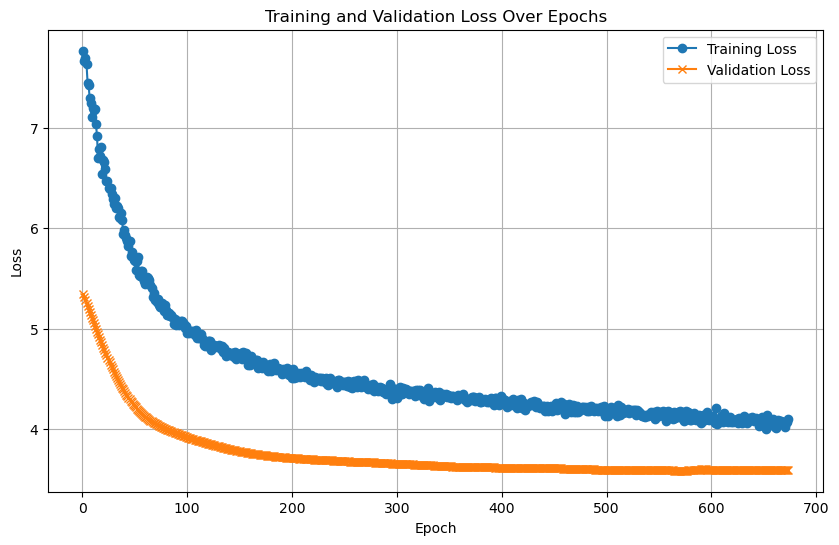

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 4.9871
Test Batch [20/20], Loss: 4.8957

Test Loss: 4.9264


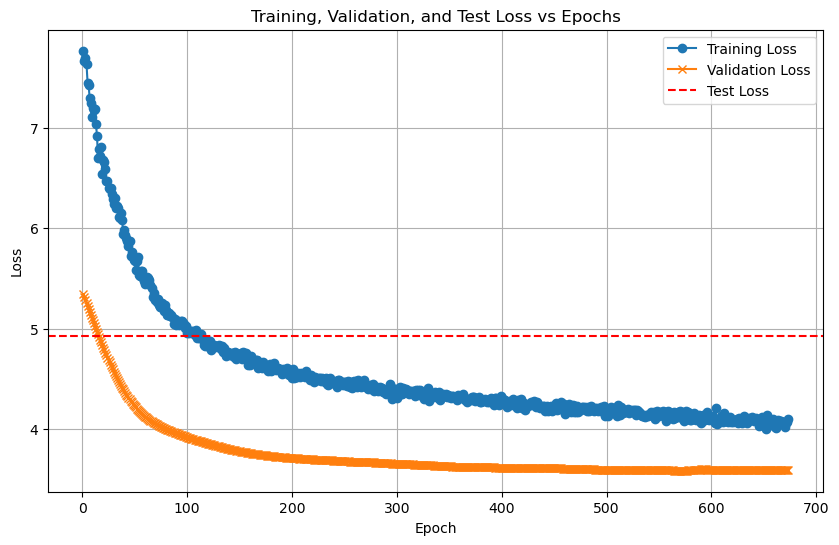

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 40.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.17      0.20      0.18         5
           5       0.50      0.40      0.44         5
           6       0.33      1.00      0.50         5
           7       0.29      0.40      0.33         5
           8       0.38      0.60      0.46         5
           9       0.50      0.20      0.29         5
          10       0.62      1.00      0.77         5
          11       1.00      0.40      0.57         5
          12       0.80      0.80      0.80         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6077  |  Val Loss: 2.6126
Validation loss improved from inf to 2.6126.
[Epoch 2/1000] Train Loss: 2.5909  |  Val Loss: 2.6025
Validation loss improved from 2.6126 to 2.6025.
[Epoch 3/1000] Train Loss: 2.5824  |  Val Loss: 2.5954
Validation loss improved from 2.6025 to 2.5954.
[Epoch 4/1000] Train Loss: 2.5732  |  Val Loss: 2.5899
Validation loss improved from 2.5954 to 2.5899.
[Epoch 5/1000] Train Loss: 2.5667  |  Val Loss: 2.5850
Validation loss improved from 2.5899 to 2.5850.
[Epoch 6/1000] Train Loss: 2.5607  |  Val Loss: 2.5808
Validation loss improved from 2.5850 to 2.5808.
[Epoch 7/1000] Train Loss: 2.5549  |  Val Loss: 2.5765
Validation loss improved from 2.5808 to 2.5765.
[Epoch 8/1000] Train Loss: 2.5499  |  Val Loss: 2.5718
Validation loss improved from 2.5765 to 2.5718.
[Epoch 9/1000] Train Loss: 2.5445  |  Val Loss: 2.5669
Validation loss improved from 2.5718 to 2.5669.
[Epoch 10/1000] Train Loss: 2.5392  |  Val Loss: 2.5628
Validation loss impr

[Epoch 18/1000] Train Loss: 2.5082  |  Val Loss: 2.5430
Validation loss improved from 2.5446 to 2.5430.
[Epoch 19/1000] Train Loss: 2.5053  |  Val Loss: 2.5417
Validation loss improved from 2.5430 to 2.5417.
[Epoch 20/1000] Train Loss: 2.5022  |  Val Loss: 2.5408
Validation loss improved from 2.5417 to 2.5408.
[Epoch 21/1000] Train Loss: 2.4994  |  Val Loss: 2.5400
Validation loss improved from 2.5408 to 2.5400.
[Epoch 22/1000] Train Loss: 2.4969  |  Val Loss: 2.5393
Validation loss improved from 2.5400 to 2.5393.
[Epoch 23/1000] Train Loss: 2.4946  |  Val Loss: 2.5389
Validation loss improved from 2.5393 to 2.5389.
[Epoch 24/1000] Train Loss: 2.4922  |  Val Loss: 2.5385
Validation loss improved from 2.5389 to 2.5385.


[Epoch 25/1000] Train Loss: 2.4897  |  Val Loss: 2.5380
Validation loss improved from 2.5385 to 2.5380.
[Epoch 26/1000] Train Loss: 2.4874  |  Val Loss: 2.5377
Validation loss improved from 2.5380 to 2.5377.
[Epoch 27/1000] Train Loss: 2.4850  |  Val Loss: 2.5377
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 28/1000] Train Loss: 2.4827  |  Val Loss: 2.5382
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 29/1000] Train Loss: 2.4803  |  Val Loss: 2.5401
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 30/1000] Train Loss: 2.4791  |  Val Loss: 2.5407
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 31/1000] Train Loss: 2.4764  |  Val Loss: 2.5386
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 32/1000] Train Loss: 2.4740  |  Val Loss: 2.5373
Validation loss improved from 2.5377 to 2.5373.
[Epoch 33/1000] Train Loss: 2.4718  |  Val Loss: 2.5367
Validation loss improved from 2.5373 to 2.5367.
[Epoch 34/1000] Train Loss: 2.4695

[Epoch 45/1000] Train Loss: 2.4488  |  Val Loss: 2.5259
Validation loss improved from 2.5266 to 2.5259.
[Epoch 46/1000] Train Loss: 2.4471  |  Val Loss: 2.5244
Validation loss improved from 2.5259 to 2.5244.
[Epoch 47/1000] Train Loss: 2.4456  |  Val Loss: 2.5212
Validation loss improved from 2.5244 to 2.5212.
[Epoch 48/1000] Train Loss: 2.4433  |  Val Loss: 2.5198
Validation loss improved from 2.5212 to 2.5198.
[Epoch 49/1000] Train Loss: 2.4412  |  Val Loss: 2.5187
Validation loss improved from 2.5198 to 2.5187.
[Epoch 50/1000] Train Loss: 2.4395  |  Val Loss: 2.5169
Validation loss improved from 2.5187 to 2.5169.
[Epoch 51/1000] Train Loss: 2.4380  |  Val Loss: 2.5140
Validation loss improved from 2.5169 to 2.5140.
[Epoch 52/1000] Train Loss: 2.4372  |  Val Loss: 2.5127
Validation loss improved from 2.5140 to 2.5127.


[Epoch 53/1000] Train Loss: 2.4363  |  Val Loss: 2.5115
Validation loss improved from 2.5127 to 2.5115.
[Epoch 54/1000] Train Loss: 2.4356  |  Val Loss: 2.5096
Validation loss improved from 2.5115 to 2.5096.
[Epoch 55/1000] Train Loss: 2.4353  |  Val Loss: 2.5086
Validation loss improved from 2.5096 to 2.5086.
[Epoch 56/1000] Train Loss: 2.4346  |  Val Loss: 2.5080
Validation loss improved from 2.5086 to 2.5080.
[Epoch 57/1000] Train Loss: 2.4333  |  Val Loss: 2.5076
Validation loss improved from 2.5080 to 2.5076.
[Epoch 58/1000] Train Loss: 2.4317  |  Val Loss: 2.5074
Validation loss improved from 2.5076 to 2.5074.
[Epoch 59/1000] Train Loss: 2.4297  |  Val Loss: 2.5074
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 2.4264  |  Val Loss: 2.5087
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 2.4227  |  Val Loss: 2.5107
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 2.4191  |  Val Los

[Epoch 75/1000] Train Loss: 2.3991  |  Val Loss: 2.5162
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 76/1000] Train Loss: 2.3974  |  Val Loss: 2.5191
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 77/1000] Train Loss: 2.3960  |  Val Loss: 2.5269
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 78/1000] Train Loss: 2.3949  |  Val Loss: 2.5334
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 79/1000] Train Loss: 2.3955  |  Val Loss: 2.5346
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 80/1000] Train Loss: 2.3935  |  Val Loss: 2.5291
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 81/1000] Train Loss: 2.3917  |  Val Loss: 2.5246
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 82/1000] Train Loss: 2.3898  |  Val Loss: 2.5207
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 83/1000] Train Loss: 2.3881  |  Val Loss: 2.5177
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 84/1000] Train Loss: 2.3864  |  Val Loss: 2.5157
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 85/1000] Train Loss: 2.3849  |  Val Loss: 2.5118
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 86/1000] Train Loss: 2.3838  |  Val Loss: 2.5048
Validation loss improved from 2.5074 to 2.5048.
[Epoch 87/1000] Train Loss: 2.3827  |  Val Loss: 2.5004
Validation loss improved from 2.5048 to 2.5004.
[Epoch 88/1000] Train Loss: 2.3818  |  Val Loss: 2.4983
Validation loss improved from 2.5004 to 2.4983.
[Epoch 89/1000] Train Loss: 2.3797  |  Val Loss: 2.4976
Validation loss improved from 2.4983 to 2.4976.
[Epoch 90/1000] Train Loss: 2.3786  |  Val Loss: 2.4977
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 91/1000] Train Loss: 2.3773  |  Val Loss: 2.4972
Validation loss improved from 2.4976 to 2.4972.
[Epoch 92/1000] Train Loss: 2.3767  |  Val Loss: 2.4960
Validation loss improved from 2.4972 to 2.4960.
[Epoch 93/1000] Train Loss: 2.3750  |  Val L

[Epoch 103/1000] Train Loss: 2.3588  |  Val Loss: 2.5163
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 104/1000] Train Loss: 2.3574  |  Val Loss: 2.5158
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 105/1000] Train Loss: 2.3558  |  Val Loss: 2.5149
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 106/1000] Train Loss: 2.3541  |  Val Loss: 2.5140
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 107/1000] Train Loss: 2.3523  |  Val Loss: 2.5113
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 108/1000] Train Loss: 2.3504  |  Val Loss: 2.5057
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 109/1000] Train Loss: 2.3492  |  Val Loss: 2.5025
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 110/1000] Train Loss: 2.3483  |  Val Loss: 2.5003
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 111/1000] Train Loss: 2.3471  |  Val Loss: 2.4985
!! Validation loss did NOT improve !! Patience:

[Epoch 115/1000] Train Loss: 2.3422  |  Val Loss: 2.4907
Validation loss improved from 2.4940 to 2.4907.
[Epoch 116/1000] Train Loss: 2.3418  |  Val Loss: 2.4884
Validation loss improved from 2.4907 to 2.4884.
[Epoch 117/1000] Train Loss: 2.3410  |  Val Loss: 2.4884
Validation loss improved from 2.4884 to 2.4884.
[Epoch 118/1000] Train Loss: 2.3398  |  Val Loss: 2.4914
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 2.3387  |  Val Loss: 2.4941
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 2.3372  |  Val Loss: 2.4961
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 2.3359  |  Val Loss: 2.4973
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 122/1000] Train Loss: 2.3347  |  Val Loss: 2.4981
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 123/1000] Train Loss: 2.3329  |  Val Loss: 2.4986
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 124/1000] Tr

[Epoch 134/1000] Train Loss: 2.3159  |  Val Loss: 2.4930
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 135/1000] Train Loss: 2.3143  |  Val Loss: 2.4910
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 136/1000] Train Loss: 2.3127  |  Val Loss: 2.4882
Validation loss improved from 2.4884 to 2.4882.
[Epoch 137/1000] Train Loss: 2.3109  |  Val Loss: 2.4841
Validation loss improved from 2.4882 to 2.4841.
[Epoch 138/1000] Train Loss: 2.3108  |  Val Loss: 2.4815
Validation loss improved from 2.4841 to 2.4815.
[Epoch 139/1000] Train Loss: 2.3095  |  Val Loss: 2.4799
Validation loss improved from 2.4815 to 2.4799.
[Epoch 140/1000] Train Loss: 2.3082  |  Val Loss: 2.4792
Validation loss improved from 2.4799 to 2.4792.
[Epoch 141/1000] Train Loss: 2.3072  |  Val Loss: 2.4793
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 2.3058  |  Val Loss: 2.4802
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 143/1000] Train Loss: 

[Epoch 149/1000] Train Loss: 2.2959  |  Val Loss: 2.4843
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 150/1000] Train Loss: 2.2943  |  Val Loss: 2.4845
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 151/1000] Train Loss: 2.2929  |  Val Loss: 2.4849
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 152/1000] Train Loss: 2.2912  |  Val Loss: 2.4852
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 153/1000] Train Loss: 2.2897  |  Val Loss: 2.4850
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 154/1000] Train Loss: 2.2880  |  Val Loss: 2.4884
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 155/1000] Train Loss: 2.2888  |  Val Loss: 2.4964
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 156/1000] Train Loss: 2.2876  |  Val Loss: 2.4989
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 157/1000] Train Loss: 2.2868  |  Val Loss: 2.4974
!! Validation loss did NOT improve !! Patience: 

[Epoch 166/1000] Train Loss: 2.2739  |  Val Loss: 2.4927
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 167/1000] Train Loss: 2.2727  |  Val Loss: 2.4930
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 168/1000] Train Loss: 2.2715  |  Val Loss: 2.4928
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 169/1000] Train Loss: 2.2700  |  Val Loss: 2.4922
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 170/1000] Train Loss: 2.2684  |  Val Loss: 2.4877
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 171/1000] Train Loss: 2.2658  |  Val Loss: 2.4789
Validation loss improved from 2.4792 to 2.4789.
[Epoch 172/1000] Train Loss: 2.2636  |  Val Loss: 2.4727
Validation loss improved from 2.4789 to 2.4727.
[Epoch 173/1000] Train Loss: 2.2622  |  Val Loss: 2.4689
Validation loss improved from 2.4727 to 2.4689.
[Epoch 174/1000] Train Loss: 2.2610  |  Val Loss: 2.4668
Validation loss improved from 2.4689 to 2.4668.
[Epoch 175/1000] Tra

[Epoch 177/1000] Train Loss: 2.2578  |  Val Loss: 2.4630
Validation loss improved from 2.4648 to 2.4630.
[Epoch 178/1000] Train Loss: 2.2565  |  Val Loss: 2.4583
Validation loss improved from 2.4630 to 2.4583.
[Epoch 179/1000] Train Loss: 2.2552  |  Val Loss: 2.4554
Validation loss improved from 2.4583 to 2.4554.
[Epoch 180/1000] Train Loss: 2.2541  |  Val Loss: 2.4536
Validation loss improved from 2.4554 to 2.4536.
[Epoch 181/1000] Train Loss: 2.2529  |  Val Loss: 2.4520
Validation loss improved from 2.4536 to 2.4520.
[Epoch 182/1000] Train Loss: 2.2520  |  Val Loss: 2.4513
Validation loss improved from 2.4520 to 2.4513.
[Epoch 183/1000] Train Loss: 2.2506  |  Val Loss: 2.4517
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 184/1000] Train Loss: 2.2488  |  Val Loss: 2.4524
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 185/1000] Train Loss: 2.2469  |  Val Loss: 2.4537
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 186/1000] Train Loss: 2.2448  

[Epoch 193/1000] Train Loss: 2.2406  |  Val Loss: 2.4801
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 194/1000] Train Loss: 2.2404  |  Val Loss: 2.4809
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 195/1000] Train Loss: 2.2397  |  Val Loss: 2.4831
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 196/1000] Train Loss: 2.2393  |  Val Loss: 2.4877
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 197/1000] Train Loss: 2.2388  |  Val Loss: 2.4900
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 198/1000] Train Loss: 2.2369  |  Val Loss: 2.4898
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 199/1000] Train Loss: 2.2330  |  Val Loss: 2.4873
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 200/1000] Train Loss: 2.2270  |  Val Loss: 2.4819
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 201/1000] Train Loss: 2.2234  |  Val Loss: 2.4713
!! Validation loss did NOT improve !! Patience:

[Epoch 210/1000] Train Loss: 2.2117  |  Val Loss: 2.4724
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 211/1000] Train Loss: 2.2078  |  Val Loss: 2.4821
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 212/1000] Train Loss: 2.2100  |  Val Loss: 2.4898
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 213/1000] Train Loss: 2.2106  |  Val Loss: 2.4944
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 214/1000] Train Loss: 2.2121  |  Val Loss: 2.4912
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 215/1000] Train Loss: 2.2084  |  Val Loss: 2.4795
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 216/1000] Train Loss: 2.2036  |  Val Loss: 2.4722
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 217/1000] Train Loss: 2.2001  |  Val Loss: 2.4671
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 218/1000] Train Loss: 2.1982  |  Val Loss: 2.4634
!! Validation loss did NOT improve !! Patience:

[Epoch 225/1000] Train Loss: 2.1930  |  Val Loss: 2.4425
Validation loss improved from 2.4445 to 2.4425.
[Epoch 226/1000] Train Loss: 2.1925  |  Val Loss: 2.4413
Validation loss improved from 2.4425 to 2.4413.
[Epoch 227/1000] Train Loss: 2.1914  |  Val Loss: 2.4406
Validation loss improved from 2.4413 to 2.4406.
[Epoch 228/1000] Train Loss: 2.1899  |  Val Loss: 2.4402
Validation loss improved from 2.4406 to 2.4402.
[Epoch 229/1000] Train Loss: 2.1880  |  Val Loss: 2.4404
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 2.1855  |  Val Loss: 2.4405
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 2.1833  |  Val Loss: 2.4410
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 232/1000] Train Loss: 2.1812  |  Val Loss: 2.4417
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 233/1000] Train Loss: 2.1789  |  Val Loss: 2.4425
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 234/1000] Train Lo

[Epoch 236/1000] Train Loss: 2.1735  |  Val Loss: 2.4432
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 237/1000] Train Loss: 2.1726  |  Val Loss: 2.4429
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 238/1000] Train Loss: 2.1712  |  Val Loss: 2.4434
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 239/1000] Train Loss: 2.1701  |  Val Loss: 2.4456
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 240/1000] Train Loss: 2.1677  |  Val Loss: 2.4520
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 241/1000] Train Loss: 2.1689  |  Val Loss: 2.4613
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 242/1000] Train Loss: 2.1692  |  Val Loss: 2.4681
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 243/1000] Train Loss: 2.1689  |  Val Loss: 2.4723
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 244/1000] Train Loss: 2.1692  |  Val Loss: 2.4747
!! Validation loss did NOT improve !! Patience: 1

[Epoch 255/1000] Train Loss: 2.1482  |  Val Loss: 2.4519
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 256/1000] Train Loss: 2.1467  |  Val Loss: 2.4545
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 257/1000] Train Loss: 2.1452  |  Val Loss: 2.4565
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 258/1000] Train Loss: 2.1439  |  Val Loss: 2.4579
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 259/1000] Train Loss: 2.1422  |  Val Loss: 2.4586
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 260/1000] Train Loss: 2.1404  |  Val Loss: 2.4555
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 261/1000] Train Loss: 2.1380  |  Val Loss: 2.4473
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 262/1000] Train Loss: 2.1359  |  Val Loss: 2.4413
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 263/1000] Train Loss: 2.1347  |  Val Loss: 2.4374
Validation loss improved from 2.4402 to 2.4374.

[Epoch 264/1000] Train Loss: 2.1336  |  Val Loss: 2.4349
Validation loss improved from 2.4374 to 2.4349.
[Epoch 265/1000] Train Loss: 2.1320  |  Val Loss: 2.4337
Validation loss improved from 2.4349 to 2.4337.
[Epoch 266/1000] Train Loss: 2.1306  |  Val Loss: 2.4330
Validation loss improved from 2.4337 to 2.4330.
[Epoch 267/1000] Train Loss: 2.1288  |  Val Loss: 2.4319
Validation loss improved from 2.4330 to 2.4319.
[Epoch 268/1000] Train Loss: 2.1269  |  Val Loss: 2.4296
Validation loss improved from 2.4319 to 2.4296.
[Epoch 269/1000] Train Loss: 2.1253  |  Val Loss: 2.4289
Validation loss improved from 2.4296 to 2.4289.
[Epoch 270/1000] Train Loss: 2.1233  |  Val Loss: 2.4305
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 2.1211  |  Val Loss: 2.4321
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 272/1000] Train Loss: 2.1192  |  Val Loss: 2.4341
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 273/1000] Train Loss: 2.1169  

[Epoch 283/1000] Train Loss: 2.0994  |  Val Loss: 2.4322
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 284/1000] Train Loss: 2.0991  |  Val Loss: 2.4312
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 285/1000] Train Loss: 2.0985  |  Val Loss: 2.4307
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 286/1000] Train Loss: 2.0972  |  Val Loss: 2.4302
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 287/1000] Train Loss: 2.0955  |  Val Loss: 2.4296
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 288/1000] Train Loss: 2.0939  |  Val Loss: 2.4292
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 289/1000] Train Loss: 2.0919  |  Val Loss: 2.4297
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 290/1000] Train Loss: 2.0893  |  Val Loss: 2.4308
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 291/1000] Train Loss: 2.0856  |  Val Loss: 2.4322
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 292/1000] Train Loss: 2.0833  |  Val Loss: 2.4335
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 293/1000] Train Loss: 2.0811  |  Val Loss: 2.4349
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 294/1000] Train Loss: 2.0793  |  Val Loss: 2.4359
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 295/1000] Train Loss: 2.0777  |  Val Loss: 2.4365
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 296/1000] Train Loss: 2.0760  |  Val Loss: 2.4369
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 297/1000] Train Loss: 2.0743  |  Val Loss: 2.4373
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 298/1000] Train Loss: 2.0727  |  Val Loss: 2.4375
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 299/1000] Train Loss: 2.0711  |  Val Loss: 2.4375
!! Validation loss did NOT improve !! Patience:

[Epoch 313/1000] Train Loss: 2.0486  |  Val Loss: 2.4370
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 314/1000] Train Loss: 2.0476  |  Val Loss: 2.4380
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 315/1000] Train Loss: 2.0458  |  Val Loss: 2.4383
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 316/1000] Train Loss: 2.0439  |  Val Loss: 2.4384
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 317/1000] Train Loss: 2.0419  |  Val Loss: 2.4384
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 318/1000] Train Loss: 2.0398  |  Val Loss: 2.4342
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 319/1000] Train Loss: 2.0368  |  Val Loss: 2.4249
Validation loss improved from 2.4289 to 2.4249.
[Epoch 320/1000] Train Loss: 2.0364  |  Val Loss: 2.4192
Validation loss improved from 2.4249 to 2.4192.


[Epoch 321/1000] Train Loss: 2.0355  |  Val Loss: 2.4166
Validation loss improved from 2.4192 to 2.4166.
[Epoch 322/1000] Train Loss: 2.0345  |  Val Loss: 2.4155
Validation loss improved from 2.4166 to 2.4155.
[Epoch 323/1000] Train Loss: 2.0331  |  Val Loss: 2.4158
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 2.0309  |  Val Loss: 2.4175
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/1000] Train Loss: 2.0296  |  Val Loss: 2.4215
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 326/1000] Train Loss: 2.0277  |  Val Loss: 2.4248
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 327/1000] Train Loss: 2.0258  |  Val Loss: 2.4273
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 328/1000] Train Loss: 2.0238  |  Val Loss: 2.4294
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 329/1000] Train Loss: 2.0215  |  Val Loss: 2.4314
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 330/10

[Epoch 339/1000] Train Loss: 2.0011  |  Val Loss: 2.4479
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 340/1000] Train Loss: 2.0026  |  Val Loss: 2.4431
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 341/1000] Train Loss: 1.9990  |  Val Loss: 2.4254
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 342/1000] Train Loss: 1.9982  |  Val Loss: 2.4150
Validation loss improved from 2.4155 to 2.4150.
[Epoch 343/1000] Train Loss: 1.9978  |  Val Loss: 2.4095
Validation loss improved from 2.4150 to 2.4095.
[Epoch 344/1000] Train Loss: 1.9991  |  Val Loss: 2.4063
Validation loss improved from 2.4095 to 2.4063.
[Epoch 345/1000] Train Loss: 1.9982  |  Val Loss: 2.4051
Validation loss improved from 2.4063 to 2.4051.
[Epoch 346/1000] Train Loss: 1.9971  |  Val Loss: 2.4049
Validation loss improved from 2.4051 to 2.4049.
[Epoch 347/1000] Train Loss: 1.9948  |  Val Loss: 2.4053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss:

[Epoch 354/1000] Train Loss: 1.9741  |  Val Loss: 2.4300
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 355/1000] Train Loss: 1.9717  |  Val Loss: 2.4401
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 356/1000] Train Loss: 1.9687  |  Val Loss: 2.4474
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 357/1000] Train Loss: 1.9683  |  Val Loss: 2.4529
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 358/1000] Train Loss: 1.9659  |  Val Loss: 2.4575
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 359/1000] Train Loss: 1.9648  |  Val Loss: 2.4618
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 360/1000] Train Loss: 1.9639  |  Val Loss: 2.4660
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 361/1000] Train Loss: 1.9638  |  Val Loss: 2.4614
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 362/1000] Train Loss: 1.9614  |  Val Loss: 2.4475
!! Validation loss did NOT improve !! Patience: 1

[Epoch 371/1000] Train Loss: 1.9451  |  Val Loss: 2.4246
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 372/1000] Train Loss: 1.9411  |  Val Loss: 2.4302
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 373/1000] Train Loss: 1.9366  |  Val Loss: 2.4301
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 374/1000] Train Loss: 1.9359  |  Val Loss: 2.4311
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 375/1000] Train Loss: 1.9349  |  Val Loss: 2.4330
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 376/1000] Train Loss: 1.9336  |  Val Loss: 2.4351
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 377/1000] Train Loss: 1.9329  |  Val Loss: 2.4388
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 378/1000] Train Loss: 1.9318  |  Val Loss: 2.4415
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 379/1000] Train Loss: 1.9301  |  Val Loss: 2.4440
!! Validation loss did NOT improve !! Patience:

[Epoch 382/1000] Train Loss: 1.9261  |  Val Loss: 2.4624
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 383/1000] Train Loss: 1.9322  |  Val Loss: 2.4734
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 384/1000] Train Loss: 1.9357  |  Val Loss: 2.4784
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 385/1000] Train Loss: 1.9364  |  Val Loss: 2.4767
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 386/1000] Train Loss: 1.9333  |  Val Loss: 2.4675
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 387/1000] Train Loss: 1.9278  |  Val Loss: 2.4588
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 388/1000] Train Loss: 1.9222  |  Val Loss: 2.4504
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 389/1000] Train Loss: 1.9176  |  Val Loss: 2.4429
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 390/1000] Train Loss: 1.9122  |  Val Loss: 2.4372
!! Validation loss did NOT improve !! Patience:

[Epoch 399/1000] Train Loss: 1.8924  |  Val Loss: 2.4460
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 400/1000] Train Loss: 1.8906  |  Val Loss: 2.4460
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 401/1000] Train Loss: 1.8883  |  Val Loss: 2.4451
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 402/1000] Train Loss: 1.8859  |  Val Loss: 2.4438
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 403/1000] Train Loss: 1.8835  |  Val Loss: 2.4427
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 404/1000] Train Loss: 1.8813  |  Val Loss: 2.4419
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 405/1000] Train Loss: 1.8788  |  Val Loss: 2.4419
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 406/1000] Train Loss: 1.8766  |  Val Loss: 2.4419
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 407/1000] Train Loss: 1.8745  |  Val Loss: 2.4430
!! Validation loss did NOT improve !! Patience:

[Epoch 413/1000] Train Loss: 1.8744  |  Val Loss: 2.4723
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 414/1000] Train Loss: 1.8723  |  Val Loss: 2.4692
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 415/1000] Train Loss: 1.8676  |  Val Loss: 2.4617
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 416/1000] Train Loss: 1.8630  |  Val Loss: 2.4547
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 417/1000] Train Loss: 1.8591  |  Val Loss: 2.4489
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 418/1000] Train Loss: 1.8561  |  Val Loss: 2.4440
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 419/1000] Train Loss: 1.8543  |  Val Loss: 2.4492
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 420/1000] Train Loss: 1.8543  |  Val Loss: 2.4712
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 421/1000] Train Loss: 1.8585  |  Val Loss: 2.4860
!! Validation loss did NOT improve !! Patience:

[Epoch 431/1000] Train Loss: 1.8325  |  Val Loss: 2.4135
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 432/1000] Train Loss: 1.8353  |  Val Loss: 2.4095
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 433/1000] Train Loss: 1.8356  |  Val Loss: 2.4061
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 434/1000] Train Loss: 1.8351  |  Val Loss: 2.4050
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 435/1000] Train Loss: 1.8339  |  Val Loss: 2.4050
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 436/1000] Train Loss: 1.8325  |  Val Loss: 2.4050
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 437/1000] Train Loss: 1.8305  |  Val Loss: 2.4064
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 438/1000] Train Loss: 1.8280  |  Val Loss: 2.4087
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 439/1000] Train Loss: 1.8238  |  Val Loss: 2.4201
!! Validation loss did NOT improve !! Patience:

[Epoch 441/1000] Train Loss: 1.8266  |  Val Loss: 2.4955
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 442/1000] Train Loss: 1.8412  |  Val Loss: 2.5213
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 443/1000] Train Loss: 1.8617  |  Val Loss: 2.5175
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 444/1000] Train Loss: 1.8446  |  Val Loss: 2.4797
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 445/1000] Train Loss: 1.8233  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 446/1000] Train Loss: 1.8120  |  Val Loss: 2.4241
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 446 !!
No improvement for 100 epochs.


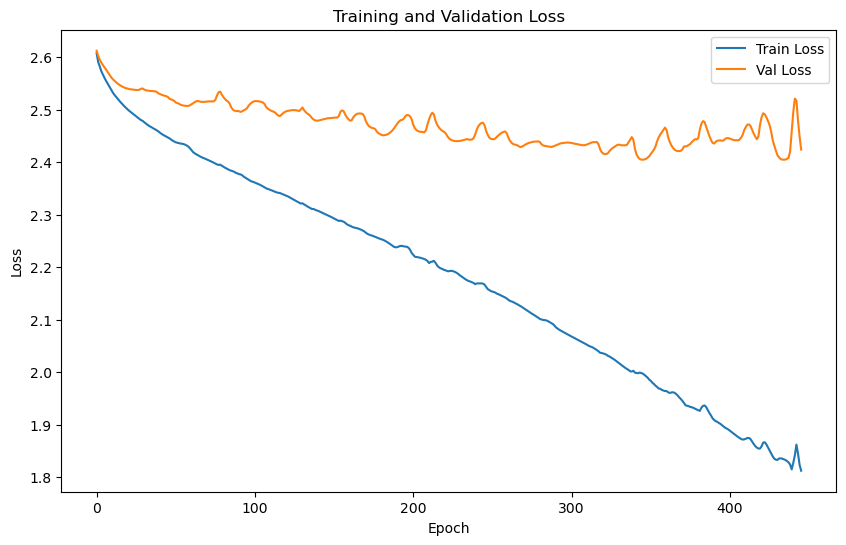

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9525 | Test Accuracy: 40.87%


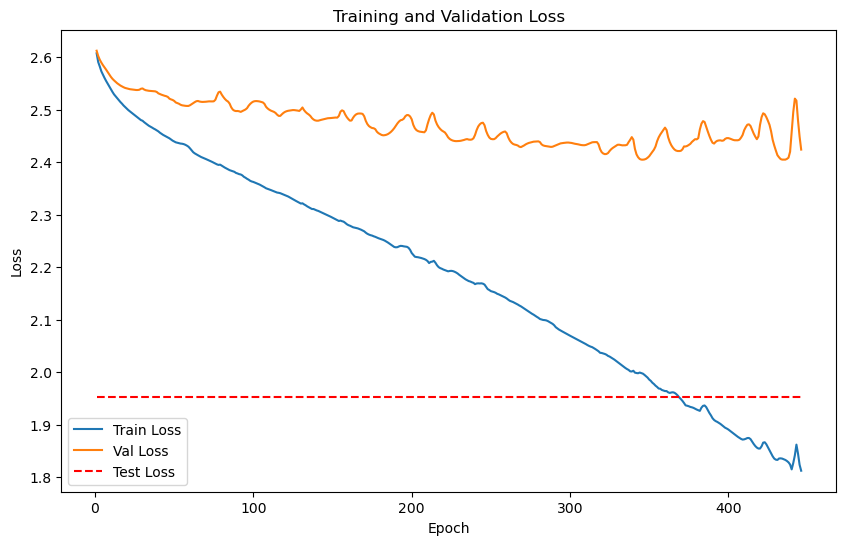

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5458
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5953
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5458, Avg Val Loss: 0.5476

Validation loss improved from inf to 0.5476. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5395
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.5942
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5395, Avg Val Loss: 0.5471

Validation loss improved from 0.5476 to 0.5471. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5388
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.5930
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5388, Avg Val Loss: 0.5465

Validation loss improved from 0.5471 to 0.5465. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5403
LOG: Epoch [4/2000] - Validation


    Batch [1/2], Val Loss: 0.5918
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5403, Avg Val Loss: 0.5459

Validation loss improved from 0.5465 to 0.5459. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.5386
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5905
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5386, Avg Val Loss: 0.5452

Validation loss improved from 0.5459 to 0.5452. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5369
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5902
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5369, Avg Val Loss: 0.5451

Validation loss improved from 0.5452 to 0.5451. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5379
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.5893
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5379, Avg Val Loss: 0.5447

Validation loss improved from 0.5451 to 0.5447. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5339
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5877


    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5339, Avg Val Loss: 0.5439

Validation loss improved from 0.5447 to 0.5439. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5352
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.5884
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5352, Avg Val Loss: 0.5442

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.5344
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5883
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5344, Avg Val Loss: 0.5442

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5266
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5868
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5266, Avg Val Loss: 0.5434

Validation loss improved from 0.5439 to 0.5434. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5294
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5866
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5294, Avg Val Loss: 0.5433

Validation loss improved from 0.5434 to 0.5433. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5299
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5845
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5299, Avg Val Loss: 0.5422

Validation loss improved from 0.5433 to 0.5422. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5259
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.5839
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5259, Avg Val Loss: 0.5420

Validation loss improved from 0.5422 to 0.5420. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5271
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.5820
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5271, Avg Val Loss: 0.5410

Validation loss improved from 0.5420 to 0.5410. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5240
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5805
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5240, Avg Val Loss: 0.5402

Validation loss improved from 0.5410 to 0.5402. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5240
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5786
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5240, Avg Val Loss: 0.5393

Validation loss improved from 0.5402 to 0.5393. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5250
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5767
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5250, Avg Val Loss: 0.5384

Validation loss improved from 0.5393 to 0.5384. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5264
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.5753
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5264, Avg Val Loss: 0.5377

Validation loss improved from 0.5384 to 0.5377. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5250
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.5736
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5250, Avg Val Loss: 0.5368

Validation loss improved from 0.5377 to 0.5368. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5286
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.5721
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5286, Avg Val Loss: 0.5361

Validation loss improved from 0.5368 to 0.5361. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5227
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5700
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5227, Avg Val Loss: 0.5350

Validation loss improved from 0.5361 to 0.5350. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5175
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5675
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5175, Avg Val Loss: 0.5338

Validation loss improved from 0.5350 to 0.5338. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5208
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.5654
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5208, Avg Val Loss: 0.5327

Validation loss improved from 0.5338 to 0.5327. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5195
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5632
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5195, Avg Val Loss: 0.5316

Validation loss improved from 0.5327 to 0.5316. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.5169
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5612
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5169, Avg Val Loss: 0.5306

Validation loss improved from 0.5316 to 0.5306. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.5157
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5584
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5157, Avg Val Loss: 0.5292

Validation loss improved from 0.5306 to 0.5292. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5195
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.5552
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5195, Avg Val Loss: 0.5276

Validation loss improved from 0.5292 to 0.5276. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5154
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5532
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5154, Avg Val Loss: 0.5266

Validation loss improved from 0.5276 to 0.5266. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.5168
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5519
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5168, Avg Val Loss: 0.5259

Validation loss improved from 0.5266 to 0.5259. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5119
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.5505
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5119, Avg Val Loss: 0.5253

Validation loss improved from 0.5259 to 0.5253. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5141
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.5490
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5141, Avg Val Loss: 0.5245

Validation loss improved from 0.5253 to 0.5245. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.5102
LOG: Epoch [33/2000] - Validation


    Batch [1/2], Val Loss: 0.5475
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5102, Avg Val Loss: 0.5237

Validation loss improved from 0.5245 to 0.5237. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5118
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5458
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5118, Avg Val Loss: 0.5229

Validation loss improved from 0.5237 to 0.5229. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5129
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.5442
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5129, Avg Val Loss: 0.5221

Validation loss improved from 0.5229 to 0.5221. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5425
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5213

Validation loss improved from 0.5221 to 0.5213. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.5102
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5409
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5102, Avg Val Loss: 0.5205

Validation loss improved from 0.5213 to 0.5205. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5109
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5395
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5109, Avg Val Loss: 0.5198

Validation loss improved from 0.5205 to 0.5198. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5092
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5381
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.5191

Validation loss improved from 0.5198 to 0.5191. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.5146
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5367
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5146, Avg Val Loss: 0.5183

Validation loss improved from 0.5191 to 0.5183. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5084
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5084, Avg Val Loss: 0.5176

Validation loss improved from 0.5183 to 0.5176. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5340
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5170

Validation loss improved from 0.5176 to 0.5170. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5121
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5329
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5121, Avg Val Loss: 0.5164

Validation loss improved from 0.5170 to 0.5164. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5082
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5082, Avg Val Loss: 0.5159

Validation loss improved from 0.5164 to 0.5159. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5068
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5154

Validation loss improved from 0.5159 to 0.5154. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5300
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5150

Validation loss improved from 0.5154 to 0.5150. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5050
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5050, Avg Val Loss: 0.5146

Validation loss improved from 0.5150 to 0.5146. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5143

Validation loss improved from 0.5146 to 0.5143. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [49/2000] - Validation


    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5139

Validation loss improved from 0.5143 to 0.5139. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5052
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5271
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5052, Avg Val Loss: 0.5136

Validation loss improved from 0.5139 to 0.5136. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5132

Validation loss improved from 0.5136 to 0.5132. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5128

Validation loss improved from 0.5132 to 0.5128. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5124

Validation loss improved from 0.5128 to 0.5124. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5120

Validation loss improved from 0.5124 to 0.5120. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5016
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5232
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5116

Validation loss improved from 0.5120 to 0.5116. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5112

Validation loss improved from 0.5116 to 0.5112. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5110

Validation loss improved from 0.5112 to 0.5110. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5107

Validation loss improved from 0.5110 to 0.5107. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5105

Validation loss improved from 0.5107 to 0.5105. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5103

Validation loss improved from 0.5105 to 0.5103. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5013
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.5205
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5047
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5047, Avg Val Loss: 0.5102

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5015
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5015, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5100

Validation loss improved from 0.5101 to 0.5100. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.5098

Validation loss improved from 0.5100 to 0.5098. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5039
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.5096

Validation loss improved from 0.5098 to 0.5096. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5185
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5092

Validation loss improved from 0.5096 to 0.5092. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5088

Validation loss improved from 0.5092 to 0.5088. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5084

Validation loss improved from 0.5088 to 0.5084. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5080

Validation loss improved from 0.5084 to 0.5080. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.5077

Validation loss improved from 0.5080 to 0.5077. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5075

Validation loss improved from 0.5077 to 0.5075. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5073

Validation loss improved from 0.5075 to 0.5073. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.5071

Validation loss improved from 0.5073 to 0.5071. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5015
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5015, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5071

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [86/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5071

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5071

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5076

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5076

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5149


    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5067

Validation loss improved from 0.5069 to 0.5067. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5063

Validation loss improved from 0.5067 to 0.5063. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.5117
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5059

Validation loss improved from 0.5063 to 0.5059. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5055

Validation loss improved from 0.5059 to 0.5055. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5051

Validation loss improved from 0.5055 to 0.5051. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5097
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5048

Validation loss improved from 0.5051 to 0.5048. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5046

Validation loss improved from 0.5048 to 0.5046. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.5043

Validation loss improved from 0.5046 to 0.5043. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5041

Validation loss improved from 0.5043 to 0.5041. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5039

Validation loss improved from 0.5041 to 0.5039. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5037

Validation loss improved from 0.5039 to 0.5037. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5035

Validation loss improved from 0.5036 to 0.5035. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5032

Validation loss improved from 0.5034 to 0.5032. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5029

Validation loss improved from 0.5030 to 0.5029. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5055
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5028

Validation loss improved from 0.5028 to 0.5028. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5027

Validation loss improved from 0.5028 to 0.5027. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5026

Validation loss improved from 0.5027 to 0.5026. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [126/2000] - Validation


    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5025

Validation loss improved from 0.5026 to 0.5025. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5025

Validation loss improved from 0.5025 to 0.5025. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5024

Validation loss improved from 0.5025 to 0.5024. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5024

Validation loss improved from 0.5024 to 0.5024. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5021

Validation loss improved from 0.5021 to 0.5021. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [137/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5021

Validation loss improved from 0.5021 to 0.5021. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5020

Validation loss improved from 0.5020 to 0.5020. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [140/2000] - Validation


    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5019

Validation loss improved from 0.5020 to 0.5019. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.5038
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5019

Validation loss improved from 0.5019 to 0.5019. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.5037
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5018

Validation loss improved from 0.5019 to 0.5018. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5018

Validation loss improved from 0.5018 to 0.5018. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5018

Validation loss improved from 0.5018 to 0.5018. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5018

Validation loss improved from 0.5018 to 0.5018. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5017

Validation loss improved from 0.5018 to 0.5017. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5017

Validation loss improved from 0.5017 to 0.5017. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5017

Validation loss improved from 0.5017 to 0.5017. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5017

Validation loss improved from 0.5017 to 0.5017. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5017

Validation loss improved from 0.5017 to 0.5017. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5017

Validation loss improved from 0.5017 to 0.5017. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5016

Validation loss improved from 0.5017 to 0.5016. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5018

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [175/2000] - Validation


    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.5035
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5017

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5016

Validation loss improved from 0.5016 to 0.5016. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5015

Validation loss improved from 0.5016 to 0.5015. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [186/2000] - Validation


    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5015

Validation loss improved from 0.5015 to 0.5015. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5015

Validation loss improved from 0.5015 to 0.5015. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5015

Validation loss improved from 0.5015 to 0.5015. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [189/2000] - Validation


    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5015

Validation loss improved from 0.5015 to 0.5015. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5015

Validation loss improved from 0.5015 to 0.5015. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5014

Validation loss improved from 0.5015 to 0.5014. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [200/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5013

Validation loss improved from 0.5014 to 0.5013. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

Validation loss improved from 0.5013 to 0.5012. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [221/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [233/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [244/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [247/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [253/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [261/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [294/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [326/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [340/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [341/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [360/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [366/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [372/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [375/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [379/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [382/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [396/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4966
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4966, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [407/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [408/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [410/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [411/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [412/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [417/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [418/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [421/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [422/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [431/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [432/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [435/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [439/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [454/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [455/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [456/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [458/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [462/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [469/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [474/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [475/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [481/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [482/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [483/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [486/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [489/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [492/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [495/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [498/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [500/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [513/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [514/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [520/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [524/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [530/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [531/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [532/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [537/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [540/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [545/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [546/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [547/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [552/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [563/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [568/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [571/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [575/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [576/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [577/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [578/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [581/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [582/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [585/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [586/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [589/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [592/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [594/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [596/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [601/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [605/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [611/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [615/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [618/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [619/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [620/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [621/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [622/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [623/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [625/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [626/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [628/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [629/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [630/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [630/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [631/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [631/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [632/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [633/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [634/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [634/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [635/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [635/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [636/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [636/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [637/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [638/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [639/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [639/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [640/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [641/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [642/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [642/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [643/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [643/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [644/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [645/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [646/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [646/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

Validation loss improved from 0.5012 to 0.5011. Saving model...
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [647/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [648/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [649/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [650/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [651/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [651/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [652/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [652/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [653/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [654/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [655/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [656/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [656/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [657/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [657/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [658/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [658/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [659/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [659/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [660/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [661/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [662/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [663/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [664/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [664/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [665/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [665/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [666/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [667/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [668/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [668/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [669/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [669/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [670/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [671/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [672/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [673/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [674/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [674/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [675/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [676/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [677/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [678/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [679/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [679/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [679/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [680/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [681/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [682/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [683/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [683/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [684/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [684/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [685/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [685/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [686/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [687/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [688/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [688/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [689/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [690/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [691/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [691/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [692/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [693/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [694/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [695/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [695/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [696/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [696/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [697/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [697/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [698/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [698/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [699/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [700/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [701/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [701/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [702/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [703/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [704/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [704/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [705/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [706/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [707/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [708/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [708/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [709/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [710/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [711/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [711/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [712/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [713/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [714/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [715/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [716/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [716/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [717/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [717/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [718/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [718/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [719/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [719/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [720/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [721/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [722/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [723/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [723/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [723/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [724/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [724/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [725/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [726/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [727/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [728/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [729/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [729/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [730/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [730/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [731/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [732/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [733/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [734/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [734/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [735/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [736/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [737/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [737/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [738/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [738/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [739/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [739/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [740/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [741/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [742/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [742/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [743/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [744/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [745/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [745/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [746/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [747/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [748/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [749/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [749/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [750/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [750/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [751/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [752/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [753/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [753/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [754/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [755/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [755/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [756/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [757/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [758/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [759/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [759/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [760/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [761/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [761/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [762/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [763/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [764/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [764/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [765/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [765/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [766/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [766/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [767/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [768/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [769/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [770/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [770/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [771/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [771/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [772/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [773/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [774/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [775/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [776/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [776/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [777/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [777/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [778/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [779/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [780/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [780/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [781/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [781/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [782/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [782/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [783/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [784/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [785/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [786/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [786/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [787/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [787/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [788/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [789/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [790/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [790/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [791/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [792/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [793/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [793/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [794/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [794/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [795/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [795/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [795/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [796/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [796/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [797/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [797/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [798/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [799/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [800/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [800/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [801/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [801/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [802/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [802/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [803/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [804/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [805/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [805/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [806/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [807/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [808/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [809/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [809/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [810/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [811/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [812/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [813/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [813/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [814/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [814/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [815/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [816/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [817/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [817/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [818/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [819/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [820/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [820/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [821/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [821/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [822/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [822/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [823/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [823/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [824/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [825/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [826/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [827/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [828/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [828/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [829/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [830/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [831/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [832/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [833/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [834/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [834/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [835/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [836/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [837/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [838/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [839/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [839/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [840/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [840/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [841/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [842/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [843/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [843/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [844/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [844/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [845/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [845/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [846/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [846/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [847/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [848/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [849/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [850/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [850/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [851/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [852/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [853/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [853/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [854/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [855/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [856/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [856/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [857/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [857/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [858/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [859/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [860/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [860/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [861/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [861/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [861/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [862/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [862/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [863/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [864/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [865/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [865/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [866/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [866/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [867/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [867/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [868/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [869/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [870/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [870/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [871/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [871/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [872/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [873/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [874/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [874/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [875/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [876/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [877/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [877/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [878/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [878/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [879/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [879/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [880/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [881/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [882/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [882/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [883/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [883/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [884/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [885/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [886/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [886/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [887/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [888/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [889/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [889/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [890/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [891/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [892/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [892/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [893/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [894/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [895/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [896/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [897/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [897/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [898/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [899/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [900/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [901/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [901/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [902/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [903/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [904/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [905/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [905/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [906/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [906/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [907/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [908/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [909/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [910/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [911/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [912/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [912/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [913/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [914/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [915/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [916/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [916/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [917/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [918/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [919/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [920/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [921/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [922/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [923/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [924/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [924/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [925/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [926/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [927/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [927/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [928/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [928/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [929/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [930/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [931/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [932/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [932/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [933/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [933/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [934/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [935/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [936/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [937/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [937/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [938/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [939/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [940/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [941/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [941/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [942/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [943/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [944/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [944/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [945/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [945/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [946/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [946/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [947/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [948/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [949/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [949/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [950/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [951/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [952/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [953/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [954/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [954/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [955/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [956/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [957/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [957/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [958/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [959/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [960/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [961/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [961/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [962/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [963/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [964/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [965/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [965/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [966/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [967/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [968/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [968/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [968/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [969/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [969/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [969/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [970/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [970/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [970/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [971/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [971/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [972/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [973/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [973/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [973/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [974/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [974/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [975/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [976/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [977/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [977/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [978/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [978/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [979/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [980/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [981/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [981/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [982/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [982/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [983/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [983/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [984/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [984/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [985/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [986/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [987/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [987/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [988/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [988/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [989/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [990/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [991/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [992/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [993/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [994/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [994/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [995/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [996/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [997/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [998/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [999/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1000/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1000/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1001/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1002/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1002/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1003/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1004/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1005/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1006/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1006/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1007/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1008/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1009/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1009/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1010/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1010/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1010/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1011/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [1011/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1011/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1012/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1013/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1014/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1015/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1015/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1016/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1017/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1018/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1018/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1018/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1019/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1019/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1019/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1020/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1020/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1021/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1022/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1023/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1023/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1024/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1024/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1025/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1025/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1026/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1027/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1028/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1028/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1029/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1030/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1031/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1031/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1032/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1032/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1033/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1034/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1035/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1036/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1036/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1037/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1038/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1039/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1039/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1039/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1040/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [1040/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1040/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1041/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1041/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1042/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1043/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1044/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [1045/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1045/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1046/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1046/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1047/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1048/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1049/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1050/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1050/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1051/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1051/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1052/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1052/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1053/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1054/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1055/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1056/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1056/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1057/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1057/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1058/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1058/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1059/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1060/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1061/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [1062/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1062/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1063/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1064/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1065/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1066/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1067/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1067/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1068/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1068/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1069/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1070/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1070/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1071/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1071/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1072/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1073/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1074/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1075/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1075/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1076/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1077/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1078/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1078/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1079/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1079/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1080/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1080/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1081/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1081/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1081/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1082/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1082/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1083/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1084/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1084/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1084/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1085/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1086/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1087/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1088/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1088/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1089/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1089/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1090/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1091/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1092/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1092/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1093/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1094/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1094/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1095/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1096/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1097/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1097/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1098/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1099/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1100/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1100/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1101/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1102/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1103/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1103/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1104/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1105/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1106/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1106/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1107/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1107/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1108/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1109/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1109/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1110/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1111/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [1112/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1112/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1113/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1113/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1113/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1114/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1114/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1114/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1115/2000] - Training
    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [1115/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1115/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1116/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1116/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1117/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1118/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1118/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1119/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1120/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1121/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1122/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1122/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1123/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1123/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1124/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1125/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1126/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1127/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1128/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1129/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1129/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1129/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1130/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1130/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1130/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1131/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1131/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1132/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1133/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1134/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1134/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1135/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1136/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1137/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1137/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1138/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1139/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1140/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1140/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1141/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1141/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1142/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1143/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1144/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1144/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1145/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1145/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1146/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1147/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1148/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1149/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1149/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1150/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1150/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1151/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1151/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1152/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1152/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1153/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1153/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1153/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1154/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1154/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1154/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1155/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1156/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1157/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1158/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1158/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1159/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1159/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1159/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1160/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1160/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1161/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1162/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1162/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1163/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1164/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1165/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1166/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1167/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1167/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1168/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1169/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1170/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1171/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1172/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1172/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1173/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1173/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1174/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1174/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1175/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1176/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1177/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1177/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1178/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1179/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1180/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1181/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1182/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1183/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1184/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1184/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1185/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1185/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1186/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1186/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1187/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1188/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1189/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1189/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1190/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1190/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1191/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1192/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1193/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1193/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1194/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1194/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1194/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1195/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1195/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1196/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1197/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1197/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1197/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1198/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1198/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1198/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1199/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1199/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1199/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1200/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1200/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1200/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [1201/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1201/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1202/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1203/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1204/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1205/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1205/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1206/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1206/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1207/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1207/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1208/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1208/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 0.4986
LOG: Epoch [1209/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1209/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1210/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1210/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1211/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1212/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1213/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [1214/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1214/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1215/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1216/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1217/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1218/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1218/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1218/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1219/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1219/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1220/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1221/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1221/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1222/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1222/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1223/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1223/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1224/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1224/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1225/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1226/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1227/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1227/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1228/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1228/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1229/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1229/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [1230/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1230/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1230/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [1231/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1231/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1231/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1232/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1232/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1232/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1233/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1234/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1235/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1235/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1236/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1237/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1238/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1239/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1239/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1240/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1240/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1241/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1242/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1243/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1244/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1244/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1245/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1246/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1247/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1248/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1248/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1249/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1250/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1251/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1251/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1252/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1252/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1253/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1253/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1254/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1255/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1256/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1257/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1257/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1258/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1259/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1260/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1261/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1262/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1263/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1264/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1265/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1265/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1266/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1266/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1267/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1268/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1269/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1270/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1271/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1271/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1272/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1272/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1273/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1274/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1275/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1275/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1276/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1276/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1277/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1278/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1279/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1279/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [1280/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1280/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1281/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1282/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1283/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1283/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1284/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1285/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1286/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1286/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1287/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1287/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1287/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1288/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1289/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1290/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1290/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1291/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1291/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1292/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1293/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1294/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1294/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [1295/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1295/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1296/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1297/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1298/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1299/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1299/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1300/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1301/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1302/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1303/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1304/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1305/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1306/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1307/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1307/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1308/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1308/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1309/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1309/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1310/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1311/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1311/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1312/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1313/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1314/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1314/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1314/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1315/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1315/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1316/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1316/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1317/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1318/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1319/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1320/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1321/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1321/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1322/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1322/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [1323/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1323/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1324/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1324/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1325/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1326/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1327/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1328/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1328/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1329/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1329/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1329/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1330/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1331/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [1332/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1332/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1333/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1334/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1335/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1336/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1336/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1336/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1337/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1338/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1339/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1340/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1340/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1341/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1341/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1342/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1342/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1343/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1344/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [1345/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1345/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1346/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1347/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1348/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1349/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1350/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1351/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1352/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1352/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1353/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1353/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1354/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1355/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1356/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1356/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1357/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1357/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1358/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1358/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1359/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1360/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1361/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1361/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1362/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1363/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1364/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1365/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1366/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1366/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1367/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1367/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1368/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1368/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1368/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1369/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1369/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1369/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1370/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1370/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1371/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1372/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1373/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [1374/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1374/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1375/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1375/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1376/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1377/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1378/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1379/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1379/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1379/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1380/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1380/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1380/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1381/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1381/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1381/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1382/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1383/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1384/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1384/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1385/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1386/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1387/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1388/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1389/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1389/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1390/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1390/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1391/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1392/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1393/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1394/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1394/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1395/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1395/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1396/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1397/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [1398/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1398/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1399/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1400/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1401/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1401/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1402/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1402/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1403/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1404/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1405/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1406/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1406/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1406/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1407/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1408/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1409/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1409/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1410/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1410/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1411/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1412/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1413/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1413/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1414/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1414/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1415/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1416/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1416/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1416/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1417/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1417/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1417/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1418/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1418/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1418/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1419/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1419/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1420/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1421/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1422/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1423/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1424/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1425/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1425/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1425/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1426/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1427/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1428/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1428/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1429/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1430/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1431/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1432/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1433/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1434/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1434/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1435/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1436/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1437/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1437/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1438/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1439/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1440/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1441/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1442/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1443/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1444/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1445/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1445/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1446/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1447/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1448/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1449/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1449/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1450/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1451/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1452/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1453/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1453/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1454/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1455/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1456/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1457/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1458/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1458/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1459/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1459/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1460/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1460/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1460/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1461/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1461/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1462/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1463/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1463/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1463/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1464/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1464/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1464/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1465/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1465/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1466/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1467/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1467/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1467/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1468/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1468/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1469/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1470/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1471/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1471/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1472/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1473/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1474/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1475/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1475/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1476/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1477/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1478/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1478/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1479/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1480/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1481/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1481/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [1482/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1482/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1483/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1484/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1485/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1485/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1486/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1487/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1488/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1489/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1489/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1490/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1491/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1492/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1492/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1492/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [1493/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1493/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1494/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1495/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1496/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1496/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1496/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1497/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1497/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1497/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1498/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1498/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1499/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1500/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1500/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1500/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1501/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1501/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1501/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1502/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1502/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1502/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1503/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1503/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1503/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1504/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1505/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1506/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [1507/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1507/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1508/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1508/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1509/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1509/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1510/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1511/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1511/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1511/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1512/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1512/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1513/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1514/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1514/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1515/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1516/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1517/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1517/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1518/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1518/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1519/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1519/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1520/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1520/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1521/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1521/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1521/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1522/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1523/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1524/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1525/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1525/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1525/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [1526/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1526/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1527/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1528/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1529/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1529/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1530/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1530/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1531/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1531/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1532/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1532/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [1533/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1533/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1533/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1534/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1534/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1535/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1536/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1536/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1536/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1537/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1538/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1539/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1539/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1540/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1540/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1541/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1542/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1543/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1544/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1544/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1545/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1546/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1547/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1547/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1548/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1548/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1549/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1550/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1551/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1551/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1551/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1552/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1552/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1552/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1553/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1553/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1553/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1554/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1554/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1555/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1555/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1555/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1556/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1556/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1557/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1558/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1559/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1559/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1560/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1560/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1561/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1561/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1562/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1563/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1563/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1564/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1564/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1565/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1565/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1566/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1566/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1567/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1567/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1567/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1568/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1568/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1569/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1570/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1571/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1571/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1572/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1573/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1574/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1575/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1575/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1576/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1577/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1578/2000] - Training
    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1578/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1578/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1579/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1580/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1581/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1581/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1582/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1583/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1584/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1585/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1586/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1587/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1587/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1587/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1588/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1588/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1589/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1590/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1590/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1591/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1591/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1592/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1592/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1593/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1594/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1595/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1596/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1597/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1597/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1597/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1598/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1598/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1599/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1600/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1600/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1600/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1601/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1601/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1601/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1602/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1602/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1602/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1603/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1603/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1604/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1604/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1605/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1606/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1607/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1607/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1608/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1608/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1609/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1610/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1611/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1611/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1612/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1612/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.4961
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1613/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1614/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1615/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1616/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1617/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1617/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1618/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1619/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1620/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1620/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [1621/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1621/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1622/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1623/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1624/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1625/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1626/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1626/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1627/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1628/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1629/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1630/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1631/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1631/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1632/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1633/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1634/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1635/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1635/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1635/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1636/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1636/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1637/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1638/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1639/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1639/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1639/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1640/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1641/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1642/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1643/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1644/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1644/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1645/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1645/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1646/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1647/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1647/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1647/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1648/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1648/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1649/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1650/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1650/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1650/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1651/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1651/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1651/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1652/2000] - Training
    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1652/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1653/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1654/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1654/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1655/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1655/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1656/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1656/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [1657/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1657/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1658/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1658/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1659/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1660/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1660/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1661/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1662/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1662/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1663/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1664/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1665/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1666/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1666/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1667/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1668/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1669/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1669/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1670/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1671/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1672/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1672/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1672/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1673/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1673/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1674/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1675/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1676/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1677/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.4954
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1678/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1679/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1679/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1680/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1680/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1681/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1681/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1682/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1683/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1684/2000] - Training
    Batch [1/1], Train Loss: 0.4945
LOG: Epoch [1684/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1684/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1685/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1685/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1686/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1687/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1688/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1688/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1688/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1689/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1689/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1689/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1690/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1690/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1690/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1691/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1691/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1692/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1693/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1693/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1694/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1694/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1695/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1696/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1697/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1697/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1698/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1698/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1699/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1699/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1700/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1700/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1700/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1701/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1701/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1701/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1702/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1703/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1704/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1705/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1706/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1706/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1706/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1707/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1708/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1709/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1709/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1710/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1711/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1712/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1713/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1713/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1714/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1715/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1716/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1717/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1718/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1719/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1720/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1721/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1721/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1721/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1722/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1722/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1723/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1724/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1725/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1725/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1725/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1726/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1726/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1727/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1728/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1729/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1729/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1730/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1731/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1732/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1733/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1734/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1735/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1735/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1736/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1736/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1737/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1738/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1738/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1739/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1739/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1739/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1740/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1741/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1742/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1742/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1742/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1743/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1743/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1744/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1745/2000] - Training
    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [1745/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1745/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1746/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1746/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1747/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1748/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1749/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1749/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1750/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1751/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1752/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1752/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1753/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1753/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1753/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1754/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1755/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1756/2000] - Training
    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1756/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1756/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1757/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1757/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1758/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1759/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1760/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1760/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1760/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1761/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1761/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1762/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1763/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1763/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1764/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1765/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1766/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1767/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1767/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1767/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1768/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1768/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1768/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1769/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1769/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1769/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1770/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1770/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1770/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1771/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1771/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1772/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1773/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1773/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1773/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1774/2000] - Training
    Batch [1/1], Train Loss: 0.4960
LOG: Epoch [1774/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1774/2000], Avg Train Loss: 0.4960, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1775/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1775/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1775/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1776/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1777/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1778/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1778/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1778/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1779/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1779/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1779/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1780/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1780/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1781/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1782/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1783/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1783/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1783/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1784/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1784/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1785/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1785/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1786/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1787/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1788/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1789/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1790/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1790/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1790/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1791/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1791/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1792/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1793/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1794/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1794/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1794/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1795/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1795/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1796/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1797/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1798/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1798/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1799/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1800/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1801/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1802/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1802/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1802/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1803/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1803/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1804/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1805/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1805/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1805/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1806/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1806/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1807/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1808/2000] - Training
    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [1808/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1808/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1809/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1809/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1810/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1811/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1811/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1811/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1812/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1812/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1813/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1814/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1814/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1814/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1815/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1815/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1816/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1817/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1818/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1819/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1820/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [1821/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1821/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1822/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1823/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [1824/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1824/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1825/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1825/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1826/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1826/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1826/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1827/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1827/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1828/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1829/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1830/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [1830/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1830/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1831/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1831/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1832/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1833/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1833/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1833/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1834/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1834/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1835/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1836/2000] - Training
    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1836/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1836/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1837/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1837/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1838/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1839/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1840/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1840/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1841/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1841/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1842/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1843/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1843/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1843/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1844/2000] - Training
    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1844/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1845/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1846/2000] - Training
    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [1846/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1846/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1847/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1847/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1847/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1848/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1848/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1849/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1850/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1851/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1851/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1851/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1852/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1852/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1853/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1854/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1855/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1856/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1857/2000] - Training
    Batch [1/1], Train Loss: 0.4943
LOG: Epoch [1857/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1857/2000], Avg Train Loss: 0.4943, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1858/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1859/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1859/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1860/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1861/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1861/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1861/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1862/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1862/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1862/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1863/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1863/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1864/2000] - Training
    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [1864/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1864/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1865/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1865/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.4930
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1866/2000], Avg Train Loss: 0.4930, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1867/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1867/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1867/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1868/2000] - Training
    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [1868/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1868/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1869/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1869/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1870/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1871/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1871/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1871/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1872/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1872/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1873/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1874/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1875/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1876/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1876/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1877/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1877/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1878/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1879/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1880/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1881/2000] - Training
    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1881/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1881/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1882/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1882/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1883/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1884/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1884/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1884/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1885/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1885/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1886/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1887/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1888/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1889/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [1889/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1889/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1890/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1890/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1891/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1892/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1893/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1894/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1894/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1894/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1895/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1896/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1897/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1897/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1897/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1898/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1898/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1899/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1900/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1900/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1900/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1901/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1901/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1901/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1902/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1902/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1902/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1903/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1903/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1904/2000] - Training
    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [1904/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1904/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1905/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [1905/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1905/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1906/2000] - Training
    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1906/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1907/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1908/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1909/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1910/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [1910/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1910/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1911/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1911/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1911/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1912/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1912/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1913/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1914/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1915/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1915/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1915/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1916/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1916/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1916/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1917/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [1917/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1917/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1918/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1918/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1919/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1920/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1921/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1922/2000] - Training
    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [1922/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1922/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1923/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1924/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1925/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [1926/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1926/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1927/2000] - Training
    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [1927/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1927/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1928/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1928/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1929/2000] - Training
    Batch [1/1], Train Loss: 0.4914
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1929/2000], Avg Train Loss: 0.4914, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1930/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1931/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [1931/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1931/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1932/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1932/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1933/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1934/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.4929
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1935/2000], Avg Train Loss: 0.4929, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1936/2000] - Training
    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1936/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1936/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1937/2000] - Training
    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1937/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1938/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1939/2000] - Training
    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [1939/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1939/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1940/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1940/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1940/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1941/2000] - Training
    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1941/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1942/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1943/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1944/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1945/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [1945/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1945/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1946/2000] - Training
    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [1946/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1946/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1947/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [1947/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1947/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1948/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1948/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1949/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1950/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1950/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1950/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1951/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1951/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1952/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1953/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1954/2000] - Training
    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [1954/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1954/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1955/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1955/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1956/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1957/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1958/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1958/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1958/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1959/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1959/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1960/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1961/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1961/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1961/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1962/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1963/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1964/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1964/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1964/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1965/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1965/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1966/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1967/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1967/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1967/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1968/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1968/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1968/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1969/2000] - Training
    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1969/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1970/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1970/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1971/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1972/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1973/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [1973/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1973/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1974/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [1974/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1974/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1975/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1975/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1976/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1977/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1978/2000] - Training
    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [1978/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1978/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1979/2000] - Training
    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [1979/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1979/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1980/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.5023


    Batch [2/2], Val Loss: 0.5000
Epoch [1980/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1981/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [1981/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1981/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1982/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [1982/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1982/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1983/2000] - Training
    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1983/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1984/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1985/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1986/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1987/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [1987/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1987/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1988/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1988/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1989/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1990/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [1990/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1990/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1991/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [1991/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1991/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1992/2000] - Training
    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1992/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1993/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1994/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1995/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [1995/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1995/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1996/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [1996/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1996/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [1997/2000] - Training
    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1997/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1998/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [1999/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [2000/2000] - Training
    Batch [1/1], Train Loss: 0.4906
LOG: Epoch [2000/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [2000/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...


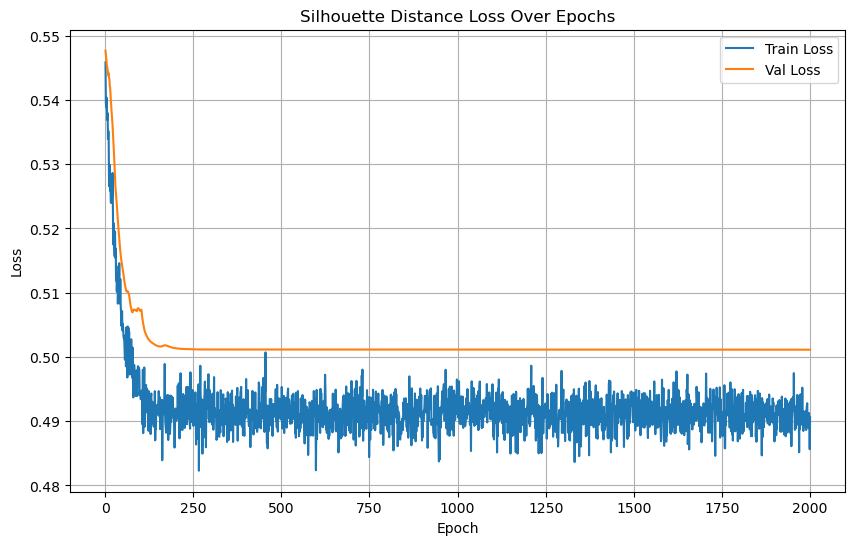

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/79], Loss: 0.3585
Test Batch [20/79], Loss: 0.1129


Test Batch [30/79], Loss: 0.4150
Test Batch [40/79], Loss: 0.3634
Test Batch [50/79], Loss: 0.2510
Test Batch [60/79], Loss: 0.4281


Test Batch [70/79], Loss: 0.2580

Test Loss: 0.3302


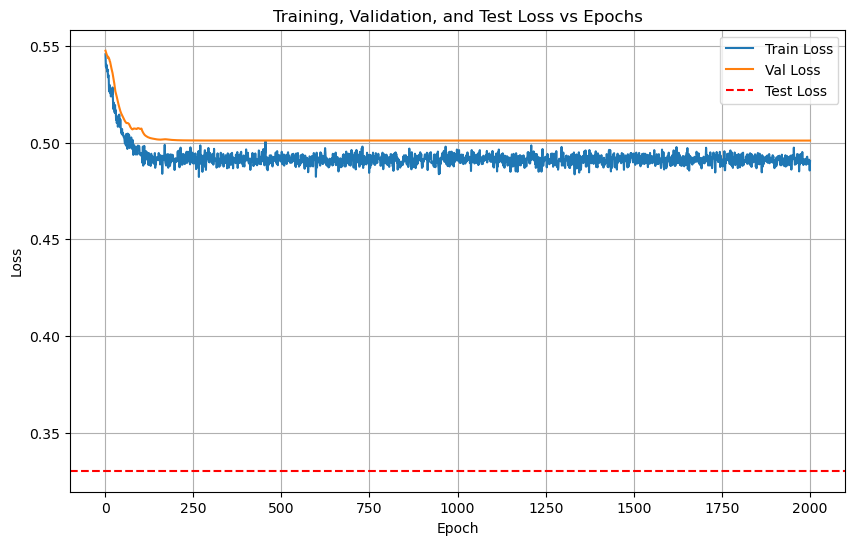

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/79 for test dataset.
  Processed batch 20/79 for test dataset.


  Processed batch 30/79 for test dataset.
  Processed batch 40/79 for test dataset.
  Processed batch 50/79 for test dataset.
  Processed batch 60/79 for test dataset.


  Processed batch 70/79 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.17      0.20      0.18         5
           5       0.44      0.80      0.57         5
           6       0.45      1.00      0.62         5
           7       0.40      0.40      0.40         5
           8       0.27      0.60      0.38         5
           9       1.00      0.20      0.33         5
          10       0.71      1.00      0.83         5
          11       1.00      0.20      0.33         5
          12       0.57      0.80      0.67         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5656  |  Val Loss: 2.5876
Validation loss improved from inf to 2.5876.
[Epoch 2/1000] Train Loss: 2.5596  |  Val Loss: 2.5860
Validation loss improved from 2.5876 to 2.5860.
[Epoch 3/1000] Train Loss: 2.5541  |  Val Loss: 2.5843
Validation loss improved from 2.5860 to 2.5843.
[Epoch 4/1000] Train Loss: 2.5499  |  Val Loss: 2.5828
Validation loss improved from 2.5843 to 2.5828.
[Epoch 5/1000] Train Loss: 2.5456  |  Val Loss: 2.5814
Validation loss improved from 2.5828 to 2.5814.
[Epoch 6/1000] Train Loss: 2.5415  |  Val Loss: 2.5802
Validation loss improved from 2.5814 to 2.5802.
[Epoch 7/1000] Train Loss: 2.5374  |  Val Loss: 2.5791
Validation loss improved from 2.5802 to 2.5791.
[Epoch 8/1000] Train Loss: 2.5335  |  Val Loss: 2.5780
Validation loss improved from 2.5791 to 2.5780.
[Epoch 9/1000] Train Loss: 2.5301  |  Val Loss: 2.5770
Validation loss improved from 2.5780 to 2.5770.
[Epoch 10/1000] Train Loss: 2.5266  |  Val Loss: 2.5760
Validation loss impr

[Epoch 20/1000] Train Loss: 2.5021  |  Val Loss: 2.5685
Validation loss improved from 2.5689 to 2.5685.
[Epoch 21/1000] Train Loss: 2.5002  |  Val Loss: 2.5682
Validation loss improved from 2.5685 to 2.5682.
[Epoch 22/1000] Train Loss: 2.4982  |  Val Loss: 2.5679
Validation loss improved from 2.5682 to 2.5679.
[Epoch 23/1000] Train Loss: 2.4963  |  Val Loss: 2.5675
Validation loss improved from 2.5679 to 2.5675.
[Epoch 24/1000] Train Loss: 2.4937  |  Val Loss: 2.5671
Validation loss improved from 2.5675 to 2.5671.
[Epoch 25/1000] Train Loss: 2.4915  |  Val Loss: 2.5667
Validation loss improved from 2.5671 to 2.5667.


[Epoch 26/1000] Train Loss: 2.4893  |  Val Loss: 2.5664
Validation loss improved from 2.5667 to 2.5664.


[Epoch 27/1000] Train Loss: 2.4877  |  Val Loss: 2.5660
Validation loss improved from 2.5664 to 2.5660.
[Epoch 28/1000] Train Loss: 2.4857  |  Val Loss: 2.5656
Validation loss improved from 2.5660 to 2.5656.
[Epoch 29/1000] Train Loss: 2.4839  |  Val Loss: 2.5651
Validation loss improved from 2.5656 to 2.5651.
[Epoch 30/1000] Train Loss: 2.4822  |  Val Loss: 2.5646
Validation loss improved from 2.5651 to 2.5646.
[Epoch 31/1000] Train Loss: 2.4805  |  Val Loss: 2.5642
Validation loss improved from 2.5646 to 2.5642.
[Epoch 32/1000] Train Loss: 2.4789  |  Val Loss: 2.5637
Validation loss improved from 2.5642 to 2.5637.
[Epoch 33/1000] Train Loss: 2.4773  |  Val Loss: 2.5631
Validation loss improved from 2.5637 to 2.5631.
[Epoch 34/1000] Train Loss: 2.4756  |  Val Loss: 2.5626
Validation loss improved from 2.5631 to 2.5626.
[Epoch 35/1000] Train Loss: 2.4741  |  Val Loss: 2.5620
Validation loss improved from 2.5626 to 2.5620.
[Epoch 36/1000] Train Loss: 2.4724  |  Val Loss: 2.5616
Validati

[Epoch 52/1000] Train Loss: 2.4437  |  Val Loss: 2.5531
Validation loss improved from 2.5543 to 2.5531.
[Epoch 53/1000] Train Loss: 2.4419  |  Val Loss: 2.5519
Validation loss improved from 2.5531 to 2.5519.
[Epoch 54/1000] Train Loss: 2.4401  |  Val Loss: 2.5505
Validation loss improved from 2.5519 to 2.5505.
[Epoch 55/1000] Train Loss: 2.4384  |  Val Loss: 2.5491
Validation loss improved from 2.5505 to 2.5491.
[Epoch 56/1000] Train Loss: 2.4365  |  Val Loss: 2.5481
Validation loss improved from 2.5491 to 2.5481.
[Epoch 57/1000] Train Loss: 2.4348  |  Val Loss: 2.5473
Validation loss improved from 2.5481 to 2.5473.


[Epoch 58/1000] Train Loss: 2.4333  |  Val Loss: 2.5467
Validation loss improved from 2.5473 to 2.5467.
[Epoch 59/1000] Train Loss: 2.4317  |  Val Loss: 2.5460
Validation loss improved from 2.5467 to 2.5460.
[Epoch 60/1000] Train Loss: 2.4300  |  Val Loss: 2.5455
Validation loss improved from 2.5460 to 2.5455.
[Epoch 61/1000] Train Loss: 2.4281  |  Val Loss: 2.5450
Validation loss improved from 2.5455 to 2.5450.
[Epoch 62/1000] Train Loss: 2.4264  |  Val Loss: 2.5445
Validation loss improved from 2.5450 to 2.5445.
[Epoch 63/1000] Train Loss: 2.4244  |  Val Loss: 2.5439
Validation loss improved from 2.5445 to 2.5439.
[Epoch 64/1000] Train Loss: 2.4227  |  Val Loss: 2.5433
Validation loss improved from 2.5439 to 2.5433.
[Epoch 65/1000] Train Loss: 2.4210  |  Val Loss: 2.5428
Validation loss improved from 2.5433 to 2.5428.
[Epoch 66/1000] Train Loss: 2.4191  |  Val Loss: 2.5423
Validation loss improved from 2.5428 to 2.5423.
[Epoch 67/1000] Train Loss: 2.4174  |  Val Loss: 2.5419
Validati

[Epoch 83/1000] Train Loss: 2.3918  |  Val Loss: 2.5353
Validation loss improved from 2.5361 to 2.5353.
[Epoch 84/1000] Train Loss: 2.3903  |  Val Loss: 2.5346
Validation loss improved from 2.5353 to 2.5346.
[Epoch 85/1000] Train Loss: 2.3887  |  Val Loss: 2.5338
Validation loss improved from 2.5346 to 2.5338.
[Epoch 86/1000] Train Loss: 2.3871  |  Val Loss: 2.5331
Validation loss improved from 2.5338 to 2.5331.
[Epoch 87/1000] Train Loss: 2.3855  |  Val Loss: 2.5324
Validation loss improved from 2.5331 to 2.5324.
[Epoch 88/1000] Train Loss: 2.3842  |  Val Loss: 2.5315
Validation loss improved from 2.5324 to 2.5315.
[Epoch 89/1000] Train Loss: 2.3825  |  Val Loss: 2.5308
Validation loss improved from 2.5315 to 2.5308.


[Epoch 90/1000] Train Loss: 2.3813  |  Val Loss: 2.5299
Validation loss improved from 2.5308 to 2.5299.
[Epoch 91/1000] Train Loss: 2.3797  |  Val Loss: 2.5291
Validation loss improved from 2.5299 to 2.5291.
[Epoch 92/1000] Train Loss: 2.3783  |  Val Loss: 2.5284
Validation loss improved from 2.5291 to 2.5284.
[Epoch 93/1000] Train Loss: 2.3770  |  Val Loss: 2.5277
Validation loss improved from 2.5284 to 2.5277.
[Epoch 94/1000] Train Loss: 2.3754  |  Val Loss: 2.5270
Validation loss improved from 2.5277 to 2.5270.
[Epoch 95/1000] Train Loss: 2.3740  |  Val Loss: 2.5262
Validation loss improved from 2.5270 to 2.5262.
[Epoch 96/1000] Train Loss: 2.3724  |  Val Loss: 2.5253
Validation loss improved from 2.5262 to 2.5253.
[Epoch 97/1000] Train Loss: 2.3706  |  Val Loss: 2.5243
Validation loss improved from 2.5253 to 2.5243.
[Epoch 98/1000] Train Loss: 2.3684  |  Val Loss: 2.5234
Validation loss improved from 2.5243 to 2.5234.
[Epoch 99/1000] Train Loss: 2.3667  |  Val Loss: 2.5226
Validati

[Epoch 114/1000] Train Loss: 2.3420  |  Val Loss: 2.5145
Validation loss improved from 2.5152 to 2.5145.
[Epoch 115/1000] Train Loss: 2.3405  |  Val Loss: 2.5139
Validation loss improved from 2.5145 to 2.5139.
[Epoch 116/1000] Train Loss: 2.3387  |  Val Loss: 2.5133
Validation loss improved from 2.5139 to 2.5133.
[Epoch 117/1000] Train Loss: 2.3372  |  Val Loss: 2.5128
Validation loss improved from 2.5133 to 2.5128.
[Epoch 118/1000] Train Loss: 2.3356  |  Val Loss: 2.5123
Validation loss improved from 2.5128 to 2.5123.
[Epoch 119/1000] Train Loss: 2.3340  |  Val Loss: 2.5118
Validation loss improved from 2.5123 to 2.5118.
[Epoch 120/1000] Train Loss: 2.3325  |  Val Loss: 2.5111
Validation loss improved from 2.5118 to 2.5111.
[Epoch 121/1000] Train Loss: 2.3308  |  Val Loss: 2.5104
Validation loss improved from 2.5111 to 2.5104.
[Epoch 122/1000] Train Loss: 2.3285  |  Val Loss: 2.5097
Validation loss improved from 2.5104 to 2.5097.


[Epoch 123/1000] Train Loss: 2.3264  |  Val Loss: 2.5090
Validation loss improved from 2.5097 to 2.5090.
[Epoch 124/1000] Train Loss: 2.3244  |  Val Loss: 2.5084
Validation loss improved from 2.5090 to 2.5084.
[Epoch 125/1000] Train Loss: 2.3228  |  Val Loss: 2.5078
Validation loss improved from 2.5084 to 2.5078.
[Epoch 126/1000] Train Loss: 2.3209  |  Val Loss: 2.5071
Validation loss improved from 2.5078 to 2.5071.
[Epoch 127/1000] Train Loss: 2.3189  |  Val Loss: 2.5065
Validation loss improved from 2.5071 to 2.5065.
[Epoch 128/1000] Train Loss: 2.3166  |  Val Loss: 2.5065
Validation loss improved from 2.5065 to 2.5065.
[Epoch 129/1000] Train Loss: 2.3143  |  Val Loss: 2.5067
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 2.3124  |  Val Loss: 2.5074
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 131/1000] Train Loss: 2.3101  |  Val Loss: 2.5080
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 132/1000] Train Loss: 2.3081  

[Epoch 146/1000] Train Loss: 2.2833  |  Val Loss: 2.5023
Validation loss improved from 2.5035 to 2.5023.
[Epoch 147/1000] Train Loss: 2.2816  |  Val Loss: 2.5014
Validation loss improved from 2.5023 to 2.5014.
[Epoch 148/1000] Train Loss: 2.2801  |  Val Loss: 2.5008
Validation loss improved from 2.5014 to 2.5008.
[Epoch 149/1000] Train Loss: 2.2786  |  Val Loss: 2.5003
Validation loss improved from 2.5008 to 2.5003.
[Epoch 150/1000] Train Loss: 2.2773  |  Val Loss: 2.5001
Validation loss improved from 2.5003 to 2.5001.
[Epoch 151/1000] Train Loss: 2.2758  |  Val Loss: 2.5000
Validation loss improved from 2.5001 to 2.5000.
[Epoch 152/1000] Train Loss: 2.2743  |  Val Loss: 2.4997
Validation loss improved from 2.5000 to 2.4997.
[Epoch 153/1000] Train Loss: 2.2728  |  Val Loss: 2.4993
Validation loss improved from 2.4997 to 2.4993.


[Epoch 154/1000] Train Loss: 2.2713  |  Val Loss: 2.4989
Validation loss improved from 2.4993 to 2.4989.
[Epoch 155/1000] Train Loss: 2.2698  |  Val Loss: 2.4986
Validation loss improved from 2.4989 to 2.4986.
[Epoch 156/1000] Train Loss: 2.2683  |  Val Loss: 2.4984
Validation loss improved from 2.4986 to 2.4984.
[Epoch 157/1000] Train Loss: 2.2667  |  Val Loss: 2.4981
Validation loss improved from 2.4984 to 2.4981.
[Epoch 158/1000] Train Loss: 2.2650  |  Val Loss: 2.4977
Validation loss improved from 2.4981 to 2.4977.
[Epoch 159/1000] Train Loss: 2.2633  |  Val Loss: 2.4973
Validation loss improved from 2.4977 to 2.4973.
[Epoch 160/1000] Train Loss: 2.2618  |  Val Loss: 2.4970
Validation loss improved from 2.4973 to 2.4970.
[Epoch 161/1000] Train Loss: 2.2606  |  Val Loss: 2.4968
Validation loss improved from 2.4970 to 2.4968.
[Epoch 162/1000] Train Loss: 2.2591  |  Val Loss: 2.4965
Validation loss improved from 2.4968 to 2.4965.
[Epoch 163/1000] Train Loss: 2.2577  |  Val Loss: 2.496

[Epoch 176/1000] Train Loss: 2.2349  |  Val Loss: 2.4914
Validation loss improved from 2.4922 to 2.4914.
[Epoch 177/1000] Train Loss: 2.2329  |  Val Loss: 2.4906
Validation loss improved from 2.4914 to 2.4906.
[Epoch 178/1000] Train Loss: 2.2307  |  Val Loss: 2.4901
Validation loss improved from 2.4906 to 2.4901.
[Epoch 179/1000] Train Loss: 2.2287  |  Val Loss: 2.4898
Validation loss improved from 2.4901 to 2.4898.
[Epoch 180/1000] Train Loss: 2.2270  |  Val Loss: 2.4896
Validation loss improved from 2.4898 to 2.4896.
[Epoch 181/1000] Train Loss: 2.2251  |  Val Loss: 2.4898
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 182/1000] Train Loss: 2.2234  |  Val Loss: 2.4900
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 183/1000] Train Loss: 2.2217  |  Val Loss: 2.4901
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 184/1000] Train Loss: 2.2200  |  Val Loss: 2.4899
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 185/1000] Train Loss: 2.

[Epoch 186/1000] Train Loss: 2.2166  |  Val Loss: 2.4904
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 187/1000] Train Loss: 2.2148  |  Val Loss: 2.4908
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 188/1000] Train Loss: 2.2132  |  Val Loss: 2.4911
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 189/1000] Train Loss: 2.2117  |  Val Loss: 2.4911
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 190/1000] Train Loss: 2.2100  |  Val Loss: 2.4908
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 191/1000] Train Loss: 2.2080  |  Val Loss: 2.4902
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 192/1000] Train Loss: 2.2057  |  Val Loss: 2.4893
Validation loss improved from 2.4896 to 2.4893.
[Epoch 193/1000] Train Loss: 2.2034  |  Val Loss: 2.4885
Validation loss improved from 2.4893 to 2.4885.
[Epoch 194/1000] Train Loss: 2.2014  |  Val Loss: 2.4876
Validation loss improved from 2.4885 to 2.4876.
[Epoch 195/1000] 

[Epoch 204/1000] Train Loss: 2.1829  |  Val Loss: 2.4809
Validation loss improved from 2.4812 to 2.4809.
[Epoch 205/1000] Train Loss: 2.1812  |  Val Loss: 2.4807
Validation loss improved from 2.4809 to 2.4807.
[Epoch 206/1000] Train Loss: 2.1795  |  Val Loss: 2.4804
Validation loss improved from 2.4807 to 2.4804.
[Epoch 207/1000] Train Loss: 2.1779  |  Val Loss: 2.4801
Validation loss improved from 2.4804 to 2.4801.
[Epoch 208/1000] Train Loss: 2.1761  |  Val Loss: 2.4798
Validation loss improved from 2.4801 to 2.4798.
[Epoch 209/1000] Train Loss: 2.1743  |  Val Loss: 2.4794
Validation loss improved from 2.4798 to 2.4794.
[Epoch 210/1000] Train Loss: 2.1724  |  Val Loss: 2.4790
Validation loss improved from 2.4794 to 2.4790.
[Epoch 211/1000] Train Loss: 2.1706  |  Val Loss: 2.4785
Validation loss improved from 2.4790 to 2.4785.


[Epoch 212/1000] Train Loss: 2.1688  |  Val Loss: 2.4781
Validation loss improved from 2.4785 to 2.4781.
[Epoch 213/1000] Train Loss: 2.1669  |  Val Loss: 2.4777
Validation loss improved from 2.4781 to 2.4777.
[Epoch 214/1000] Train Loss: 2.1651  |  Val Loss: 2.4776
Validation loss improved from 2.4777 to 2.4776.
[Epoch 215/1000] Train Loss: 2.1633  |  Val Loss: 2.4774
Validation loss improved from 2.4776 to 2.4774.
[Epoch 216/1000] Train Loss: 2.1613  |  Val Loss: 2.4772
Validation loss improved from 2.4774 to 2.4772.
[Epoch 217/1000] Train Loss: 2.1595  |  Val Loss: 2.4771
Validation loss improved from 2.4772 to 2.4771.
[Epoch 218/1000] Train Loss: 2.1574  |  Val Loss: 2.4768
Validation loss improved from 2.4771 to 2.4768.
[Epoch 219/1000] Train Loss: 2.1555  |  Val Loss: 2.4764
Validation loss improved from 2.4768 to 2.4764.
[Epoch 220/1000] Train Loss: 2.1536  |  Val Loss: 2.4759
Validation loss improved from 2.4764 to 2.4759.
[Epoch 221/1000] Train Loss: 2.1516  |  Val Loss: 2.475

[Epoch 235/1000] Train Loss: 2.1280  |  Val Loss: 2.4712
Validation loss improved from 2.4713 to 2.4712.
[Epoch 236/1000] Train Loss: 2.1260  |  Val Loss: 2.4714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 237/1000] Train Loss: 2.1239  |  Val Loss: 2.4718
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 238/1000] Train Loss: 2.1220  |  Val Loss: 2.4720
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 239/1000] Train Loss: 2.1201  |  Val Loss: 2.4721
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 240/1000] Train Loss: 2.1183  |  Val Loss: 2.4721
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 241/1000] Train Loss: 2.1165  |  Val Loss: 2.4721
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 242/1000] Train Loss: 2.1147  |  Val Loss: 2.4721
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 243/1000] Train Loss: 2.1131  |  Val Loss: 2.4722
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 247/1000] Train Loss: 2.1062  |  Val Loss: 2.4753
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 248/1000] Train Loss: 2.1049  |  Val Loss: 2.4771
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 249/1000] Train Loss: 2.1038  |  Val Loss: 2.4784
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 250/1000] Train Loss: 2.1025  |  Val Loss: 2.4787
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 251/1000] Train Loss: 2.1005  |  Val Loss: 2.4784
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 252/1000] Train Loss: 2.0986  |  Val Loss: 2.4786
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 253/1000] Train Loss: 2.0962  |  Val Loss: 2.4799
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 254/1000] Train Loss: 2.0938  |  Val Loss: 2.4806
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 255/1000] Train Loss: 2.0918  |  Val Loss: 2.4809
!! Validation loss did NOT improve !! Patience:

[Epoch 265/1000] Train Loss: 2.0734  |  Val Loss: 2.4822
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 266/1000] Train Loss: 2.0717  |  Val Loss: 2.4829
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 267/1000] Train Loss: 2.0700  |  Val Loss: 2.4839
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 268/1000] Train Loss: 2.0681  |  Val Loss: 2.4845
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 269/1000] Train Loss: 2.0664  |  Val Loss: 2.4846
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 270/1000] Train Loss: 2.0646  |  Val Loss: 2.4850
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 271/1000] Train Loss: 2.0628  |  Val Loss: 2.4860
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 272/1000] Train Loss: 2.0610  |  Val Loss: 2.4868
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 273/1000] Train Loss: 2.0589  |  Val Loss: 2.4870
!! Validation loss did NOT improve !! Patience:

[Epoch 281/1000] Train Loss: 2.0435  |  Val Loss: 2.4851
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 282/1000] Train Loss: 2.0415  |  Val Loss: 2.4844
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 283/1000] Train Loss: 2.0396  |  Val Loss: 2.4836
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 284/1000] Train Loss: 2.0376  |  Val Loss: 2.4830
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 285/1000] Train Loss: 2.0355  |  Val Loss: 2.4822
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 286/1000] Train Loss: 2.0337  |  Val Loss: 2.4806
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 287/1000] Train Loss: 2.0318  |  Val Loss: 2.4788
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 288/1000] Train Loss: 2.0300  |  Val Loss: 2.4769
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 289/1000] Train Loss: 2.0283  |  Val Loss: 2.4757
!! Validation loss did NOT improve !! Patience:

[Epoch 294/1000] Train Loss: 2.0190  |  Val Loss: 2.4732
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 295/1000] Train Loss: 2.0173  |  Val Loss: 2.4724
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 296/1000] Train Loss: 2.0156  |  Val Loss: 2.4722
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 297/1000] Train Loss: 2.0138  |  Val Loss: 2.4731
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 298/1000] Train Loss: 2.0117  |  Val Loss: 2.4747
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 299/1000] Train Loss: 2.0096  |  Val Loss: 2.4761
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 300/1000] Train Loss: 2.0075  |  Val Loss: 2.4778
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 301/1000] Train Loss: 2.0057  |  Val Loss: 2.4811
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 302/1000] Train Loss: 2.0039  |  Val Loss: 2.4837
!! Validation loss did NOT improve !! Patience:

[Epoch 307/1000] Train Loss: 1.9946  |  Val Loss: 2.4855
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 308/1000] Train Loss: 1.9925  |  Val Loss: 2.4844
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 309/1000] Train Loss: 1.9904  |  Val Loss: 2.4834
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 310/1000] Train Loss: 1.9883  |  Val Loss: 2.4826
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 311/1000] Train Loss: 1.9863  |  Val Loss: 2.4819
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 312/1000] Train Loss: 1.9842  |  Val Loss: 2.4805
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 313/1000] Train Loss: 1.9822  |  Val Loss: 2.4793
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 314/1000] Train Loss: 1.9802  |  Val Loss: 2.4781
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 315/1000] Train Loss: 1.9784  |  Val Loss: 2.4773
!! Validation loss did NOT improve !! Patience:

[Epoch 322/1000] Train Loss: 1.9638  |  Val Loss: 2.4752
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 323/1000] Train Loss: 1.9618  |  Val Loss: 2.4759
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 324/1000] Train Loss: 1.9597  |  Val Loss: 2.4771
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 325/1000] Train Loss: 1.9576  |  Val Loss: 2.4786
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 326/1000] Train Loss: 1.9553  |  Val Loss: 2.4802
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 327/1000] Train Loss: 1.9532  |  Val Loss: 2.4821
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 328/1000] Train Loss: 1.9510  |  Val Loss: 2.4847
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 329/1000] Train Loss: 1.9490  |  Val Loss: 2.4868
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 330/1000] Train Loss: 1.9471  |  Val Loss: 2.4875
!! Validation loss did NOT improve !! Patience:

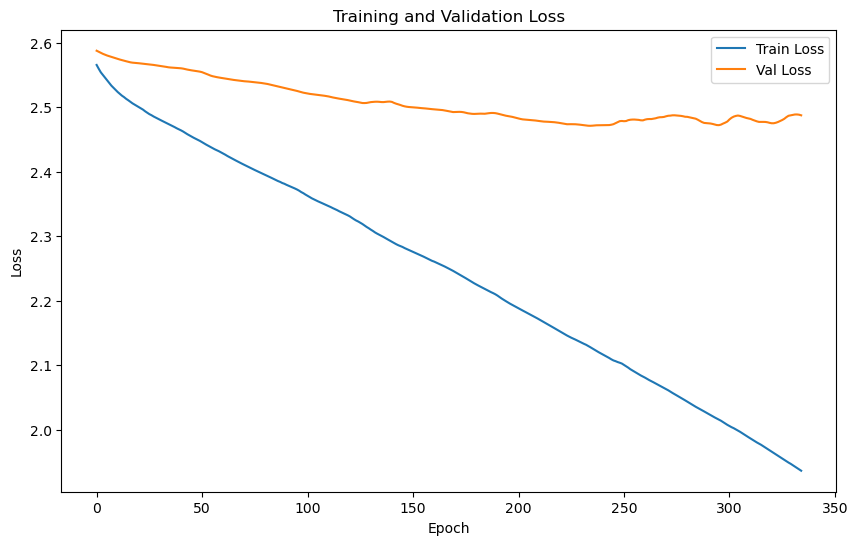

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.2438 | Test Accuracy: 42.86%


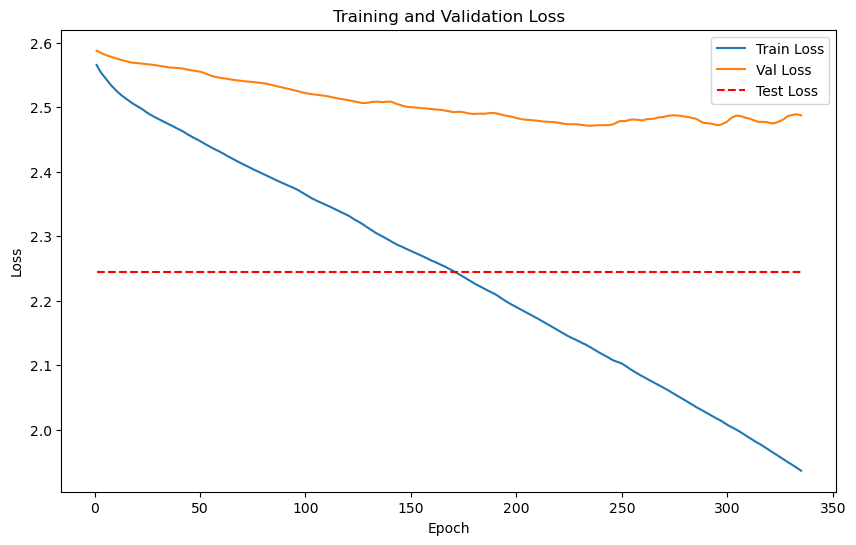

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


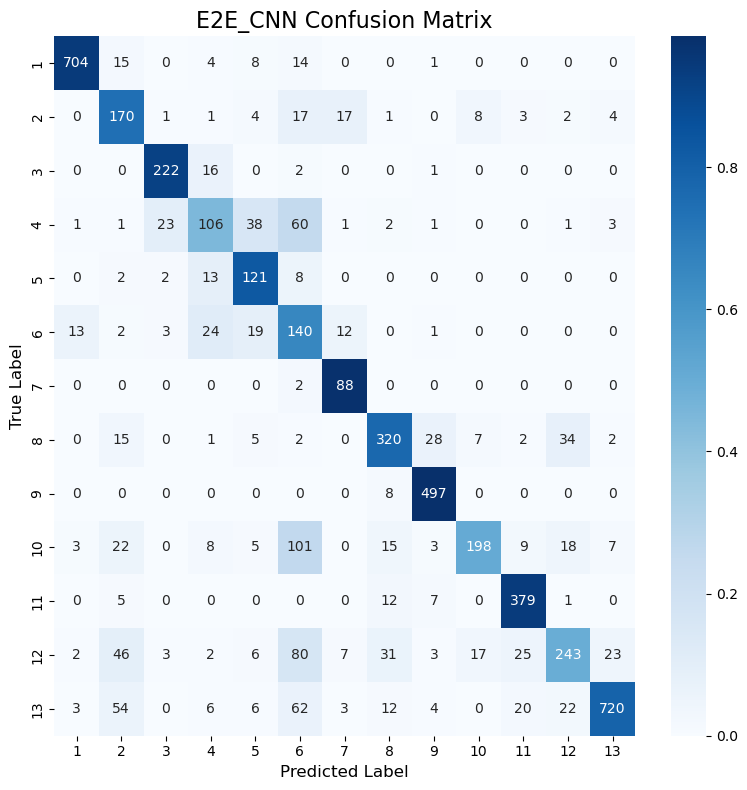

Classification Accuracy: 77.91%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


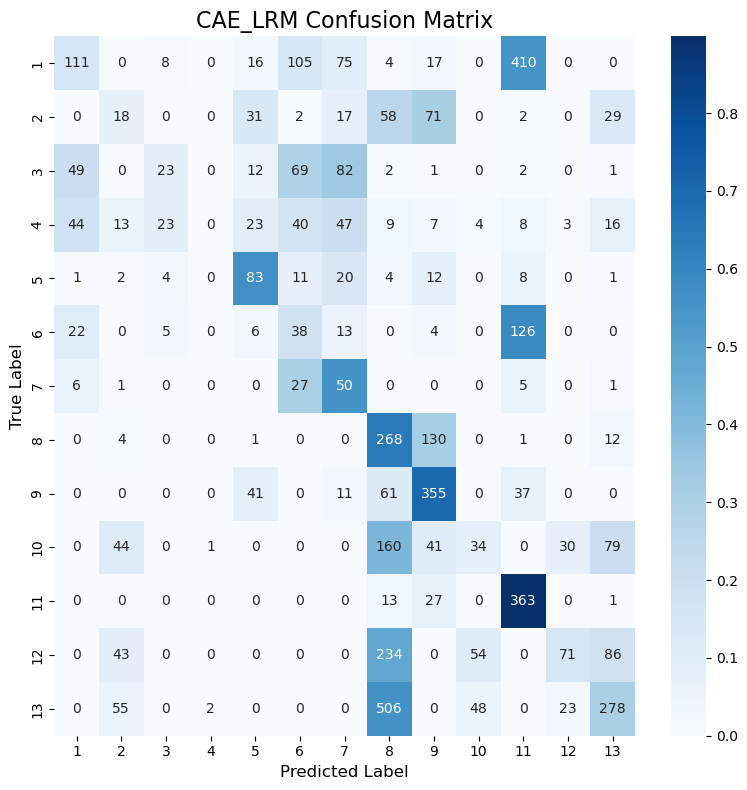

Classification Accuracy: 33.73%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


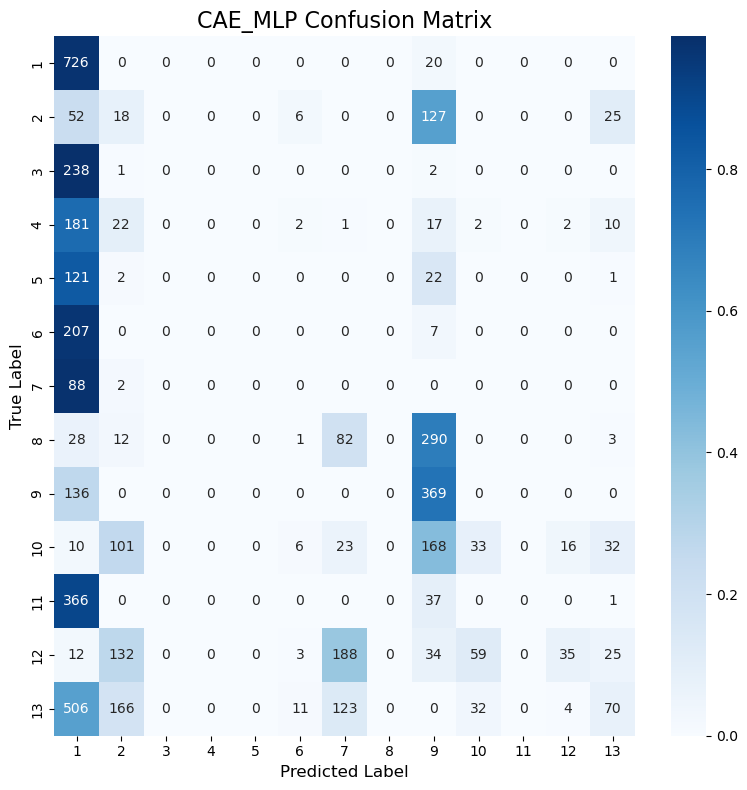

Classification Accuracy: 24.94%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


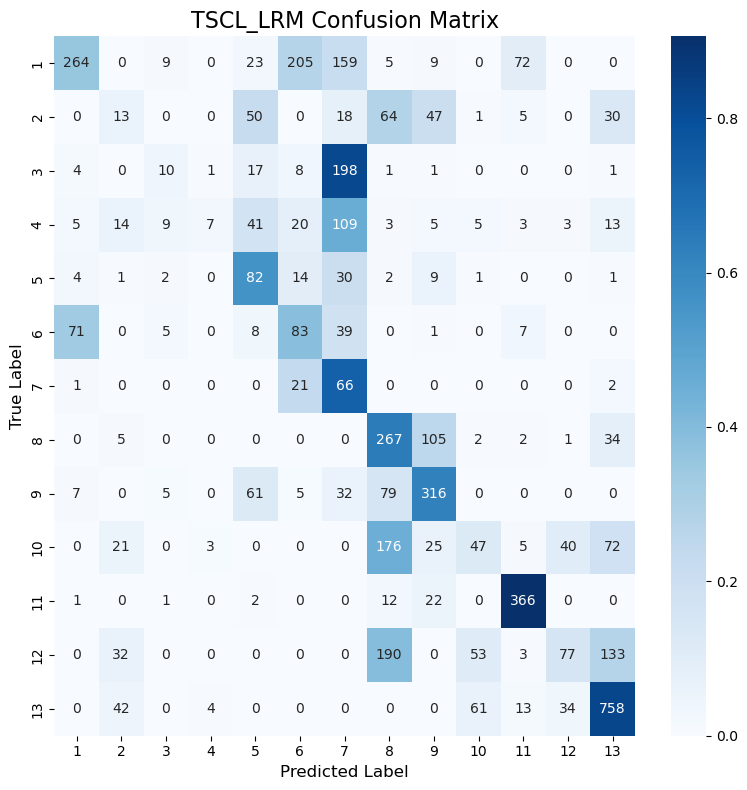

Classification Accuracy: 46.97%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


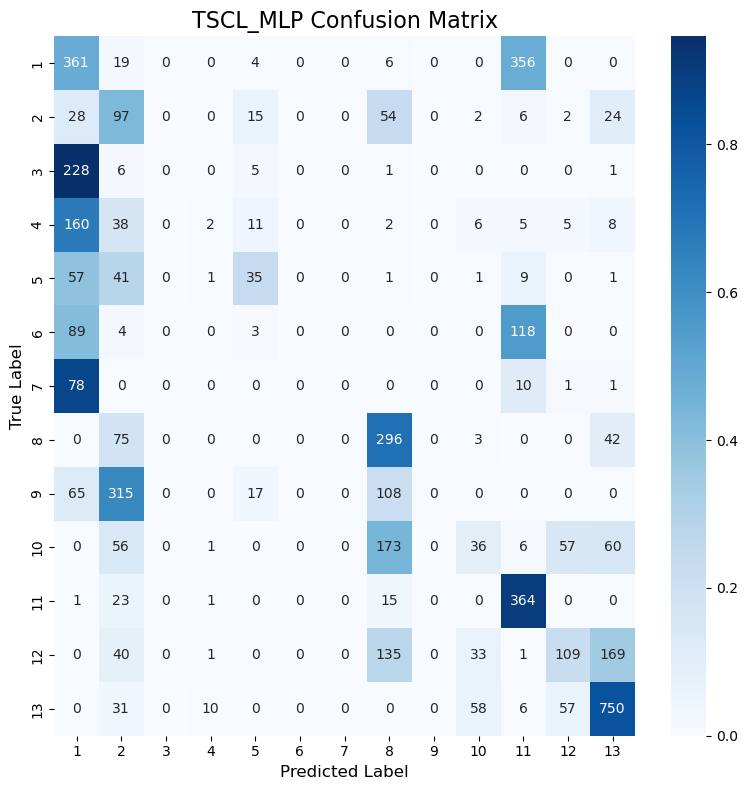

Classification Accuracy: 40.87%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


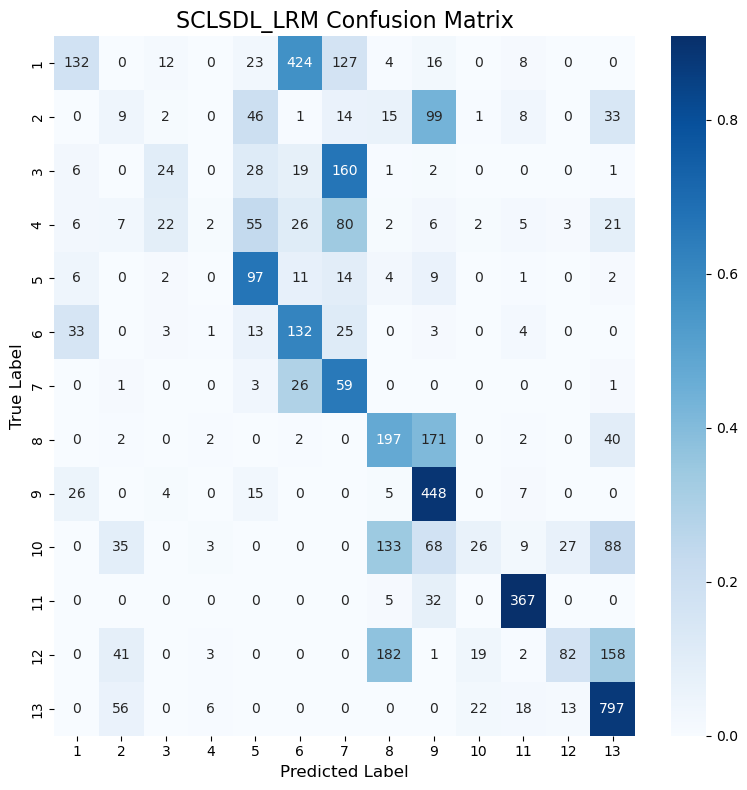

Classification Accuracy: 47.29%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


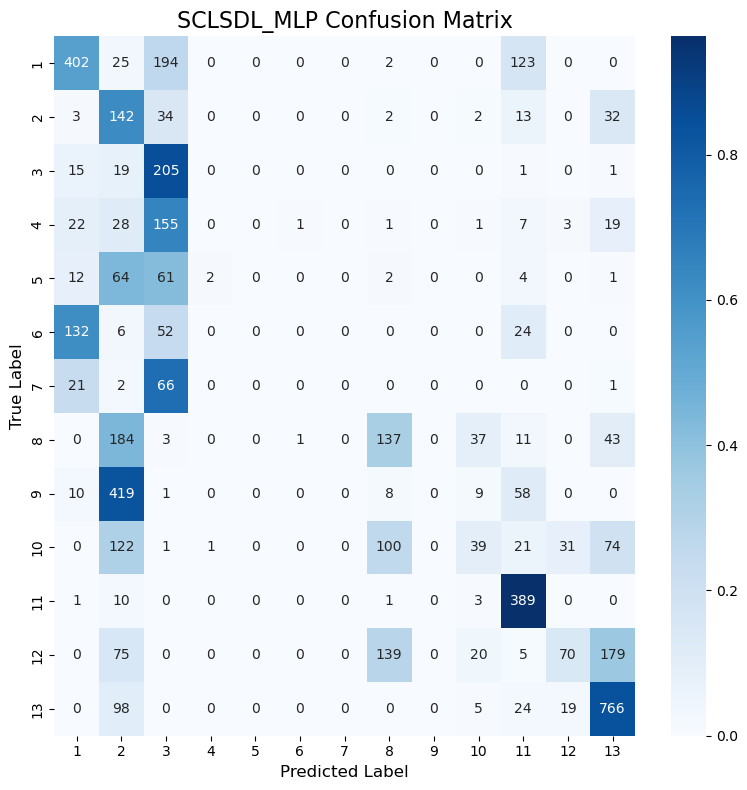

Classification Accuracy: 42.86%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          77.91
1    LRM (CAE)          33.73
2    MLP (CAE)          24.94
3     TSCL LRM          46.97
4     TSCL MLP          40.87
5  SCL_SDL LRM          47.29
6  SCL_SDL MLP          42.86

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          77.91
5  SCL_SDL LRM          47.29
3     TSCL LRM          46.97
6  SCL_SDL MLP          42.86
4     TSCL MLP          40.87
1    LRM (CAE)          33.73
2    MLP (CAE)          24.94
